In [1]:
#default_exp verbatims/sentiment/training

In [2]:
#all_slow

In [3]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Sentiment - Training

> This module contains all the bits required to train and evaluate verbatim sentiment models

In [4]:
#export
import os, datetime, gc
import sklearn.metrics as skm

from fastai.text.all import *
from transformers import *
from blurr.utils import *
from blurr.data.core import *
from blurr.modeling.core import *

from tritonlytics_ai.utils import *
from tritonlytics_ai.verbatims.core import *

In [5]:
#hide
import pdb

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

from nbdev.showdoc import *
from fastcore.test import *

In [6]:
#hide
from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.6.0
Using fastai 2.0.16
Using transformers 3.3.1


In [7]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #1


## Data

In [8]:
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = "facebook/bart-base" #"roberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(SENT_LABELS[1:])

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartForSequenceClassification: ['final_logits_bias']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.weight', 'classification_head.dense.bias', 'classification_head.out_proj.weight', 'classification_head.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to u

In [9]:
df = get_sentiment_train_data()
train_df, valid_df = df[df.is_valid == False], df[df.is_valid == True]

dls = get_sentiment_train_dls(df, hf_arch, hf_tokenizer)

In [10]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([8, 512]), torch.Size([8, 8]))

## Training

In [11]:
m_pre = f'exp_{m_pre_sentiment}'
m_suf = m_suf_sentiment

Configure our **metrics**

In [12]:
# define metrics
beta, start, end, average, sample_weight = 1, 0.08, 0.7, 'weighted', None

# custom
opt_th_metrics = OptimalMultiThresholdMetrics(beta=beta, start=start, end=end, 
                                              average=average, sample_weight=sample_weight)

opt_th_metric = opt_th_metrics.best_thresh()
opt_fscore_metric = opt_th_metrics.best_fscore()
opt_acc_metric = opt_th_metrics.best_faccuracy()

# standard
fbeta_metric = FBetaMulti(beta=beta, average=average, sample_weight=sample_weight)
prec_metric = PrecisionMulti(average=average, sample_weight=sample_weight)
recall_metric = RecallMulti(average=average, sample_weight=sample_weight)
roc_auc_metric = RocAucMulti(average=average, sample_weight=sample_weight)

In [13]:
#export
def get_metrics(train_config={}):
    config = {**sentiment_train_config, **train_config}

    beta, average, sample_weight = config['opt_beta'], config['opt_beta_average'], config['opt_beta_sample_weight']
    start, end = config['opt_start'], config['opt_end']
    
    # fbeta and roc-auc metrics
    fbeta_metric = FBetaMulti(beta=beta, average=average, sample_weight=sample_weight)
    prec_metric = PrecisionMulti(average=average, sample_weight=sample_weight)
    recall_metric = RecallMulti(average=average, sample_weight=sample_weight)
    roc_auc_metric = RocAucMulti(average=average, sample_weight=sample_weight)
    
    return [ accuracy_multi, fbeta_metric, prec_metric, recall_metric, roc_auc_metric ]

Configure our **loss**

In [14]:
label_counts = { col: train_df[col].value_counts().to_dict() for col in dls.tfms[1].vocab }
most_common_label = max(label_counts.keys(), key=(lambda k: label_counts[k][1]))

for lbl in label_counts: label_counts[lbl]['weight'] = label_counts[most_common_label][1] / label_counts[lbl][1]
    
pos_weight_vec = [v['weight'] * 1. if v['weight'] != 1.0 else v['weight'] for k,v in label_counts.items()]
# pos_weight_vec

In [15]:
# loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight_vec).to('cuda:1'))
# loss_func.thresh = 0.5
# loss_func = BCEWithLogitsLossFlat(pos_weight=tensor(pos_weight_vec*bsz, device=torch.cuda.current_device()))
loss_func = BCEWithLogitsLossFlat()

In [16]:
#export
def get_loss_func(dls, train_df=None, use_weighted=False):
    if (use_weighted and train_df is not None):
        label_counts = { col: train_df[col].value_counts().to_dict() for col in dls.tfms[1].vocab }
        most_common_label = max(label_counts.keys(), key=(lambda k: label_counts[k][1]))

        for lbl in label_counts: 
            label_counts[lbl]['weight'] = label_counts[most_common_label][1] / label_counts[lbl][1]

        pos_weight_vec = [v['weight'] * 1. if v['weight'] != 1.0 else v['weight'] for k,v in label_counts.items()]
        
        loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight_vec).to(dls.device))
        loss_func.thresh = 0.5 # adding "thresh" since we want to optimize this for our target beta
    else:
        loss_func = BCEWithLogitsLossFlat()
        
    return loss_func

In [17]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=False)
test_is(type(tst_loss_func), BCEWithLogitsLossFlat)

In [18]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=True)
test_is(type(tst_loss_func), torch.nn.BCEWithLogitsLoss)
test_eq(len(tst_loss_func.pos_weight), dls.c)
test_eq(dls.device, tst_loss_func.pos_weight.device)

Configure our **callbacks**

In [19]:
best_model_cb = SaveModelCallback(monitor='fbeta_score', 
                                  comp=np.greater, 
                                  reset_on_fit=False,
                                  fname=f'{m_pre}cls_bestmodel{m_suf}')

opt_thresh_cb = OptimizeFBetaThreshCallback(beta=beta, 
                                            average=average, 
                                            sample_weight=sample_weight,
                                            start=start, end=end)

In [20]:
#export
def get_cbs(train_config={}):
    config = {**sentiment_train_config, **train_config}
    
    best_model_cb = SaveModelCallback(monitor=config['save_model_monitor'], 
                                      comp=config['save_model_comp'], 
                                      fname=config['save_model_filename'],
                                      reset_on_fit=False)

    opt_thresh_cb = OptimizeFBetaThreshCallback(beta=config['opt_beta'], 
                                                average=config['opt_beta_average'], 
                                                sample_weight=config['opt_beta_sample_weight'],
                                                start=config['opt_start'], end=config['opt_end'])
    
    return [HF_BaseModelCallback], [best_model_cb, opt_thresh_cb] # (learn_cbs, fit_cbs)

Define our Learner

In [21]:
learn_metrics = [ accuracy_multi, fbeta_metric, prec_metric, recall_metric, roc_auc_metric ]

learn_cbs = [HF_BaseModelCallback]
fit_cbs = [best_model_cb, opt_thresh_cb]

# build learner
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam, mom=0.9, sqr_mom=0.98, eps=1e-6, weight_decay=0.1),
                loss_func=loss_func,
                metrics=learn_metrics,
                cbs=learn_cbs,
                splitter=hf_splitter,
                path=SENTIMENT_CLS_PATH)

learn.create_opt() # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [22]:
# learn.blurr_summary()

In [23]:
# learn.show_training_loop()

In [24]:
# Note: Run this to test the model and comment out afterwards as it needlessly contributes to GPU RAM utilization :(
# preds = model(b[0]); preds[0].shape

In [25]:
#export
def get_learner(hf_model, dls, train_df=None, use_weighted_loss=False, use_fp16=True,
                opt_func=partial(Adam, mom=0.9, sqr_mom=0.98, eps=1e-6, weight_decay=0.1),
                train_config={}):
    config = {**sentiment_train_config, **train_config}
    
    # build learner
    model = HF_BaseModelWrapper(hf_model)
    loss_func = get_loss_func(dls, train_df, use_weighted_loss)
    learn_cbs, fit_cbs = get_cbs(config)
    learn_metrics = get_metrics(config)

    learn = Learner(dls, model, loss_func=loss_func, opt_func=opt_func, 
                    metrics=learn_metrics, cbs=learn_cbs, splitter=hf_splitter, path=config['learner_path'])
    
    if (use_fp16): learn = learn.to_fp16()
    learn.create_opt() # -> will create your layer groups based on your "splitter" function
    learn.freeze()
    
    return learn, fit_cbs

(0.002290867641568184, 0.0004786300996784121)

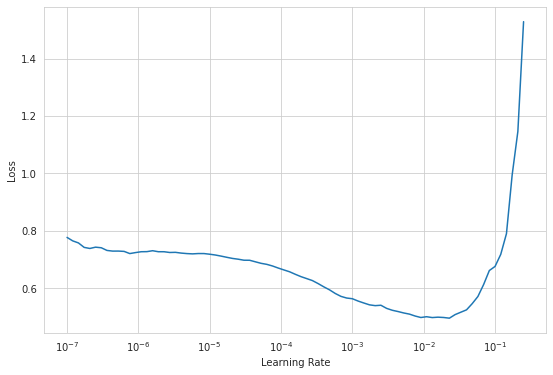

In [26]:
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [27]:
learn.fit_one_cycle(3, lr_max=lr_min, cbs=fit_cbs)
# learn.fit_flat_cos(10, lr_max=lr_min, cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.206319,0.193116,0.929966,0.760383,0.791262,0.774744,0.847041,0.440000,01:52
1,0.148679,0.150803,0.938320,0.815237,0.809732,0.835202,0.881609,0.450000,01:51
2,0.125861,0.130228,0.943941,0.830120,0.810571,0.854217,0.890754,0.420000,01:50


Better model found at epoch 0 with fbeta_score value: 0.7603825666063226.
Better model found at epoch 1 with fbeta_score value: 0.8152370864108702.
Better model found at epoch 2 with fbeta_score value: 0.8301196312481948.


(6.309573450380412e-08, 7.585775847473997e-07)

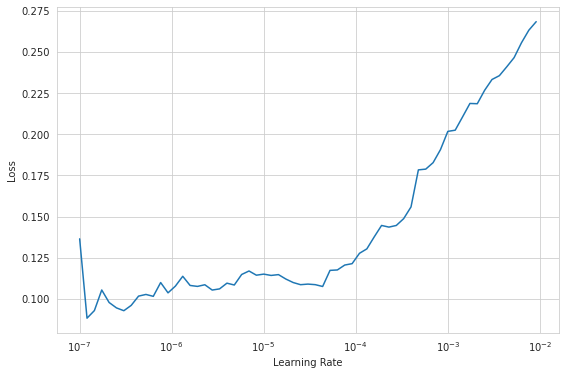

In [28]:
learn.unfreeze()
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [29]:
learn.fit_one_cycle(5, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs)
# learn.fit_flat_cos(5, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.113246,0.130287,0.944019,0.830656,0.810749,0.855193,0.891211,0.420000,03:35
1,0.118044,0.130454,0.943161,0.830049,0.805558,0.859581,0.891940,0.410000,03:35
2,0.116989,0.130522,0.943161,0.830260,0.805562,0.860068,0.892156,0.410000,03:36
3,0.118973,0.130522,0.943161,0.830249,0.805540,0.860068,0.892165,0.410000,03:35
4,0.115386,0.130525,0.943161,0.830249,0.805540,0.860068,0.892165,0.410000,03:36


Better model found at epoch 0 with fbeta_score value: 0.8306556307467039.


In [30]:
learn.loss_func.thresh # => not part of pytorch BCE loss function (so added above as needed)

0.40999999999999986

In [31]:
learn.save(f'{m_pre}cls{m_suf}')

Path('data/classification/sentiment/models/exp_cls_multilabel_hf.pth')

Export model for inference

In [32]:
learn.export(fname=f'{m_pre}export_clas{m_suf}.pkl')

Look at results

In [33]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')

In [34]:
scores = dict(zip(learn.recorder.metric_names[2:], learn.validate())); scores

{'valid_loss': 0.1302870661020279,
 'accuracy_multi': 0.9434728026390076,
 'fbeta_score': 0.830195809737756,
 'precision_score': 0.8073605957458901,
 'recall_score': 0.8581179912237933,
 'roc_auc_score': 0.8916026541930911,
 'opt_th': 0.40999999999999986}

In [35]:
# learn.show_results(learner=learn, max_n=2) 
# => ERROR:Only one class present in y_true. ROC AUC score is not defined in that case.

Use it for inference

In [36]:
inf_learn = load_learner(SENTIMENT_CLS_PATH/f'{m_pre}export_clas{m_suf}.pkl')

In [37]:
inf_learn.loss_func.thresh

0.40999999999999986

In [38]:
inf_learn.blurr_predict('We are not paid enough and the benefits are horrible')

((#2) ['is_very_negative','is_negative'],
 tensor([False, False,  True,  True, False, False, False, False]),
 tensor([6.2560e-04, 1.2769e-02, 5.7958e-01, 9.8342e-01, 1.6488e-02, 2.8457e-03,
         2.2112e-03, 5.9108e-03]))

Review final validation loss for best model

In [39]:
print(SENT_LABELS[1:])

['is_very_positive', 'is_positive', 'is_very_negative', 'is_negative', 'is_suggestion', 'feels_threatened', 'has_profanity', 'is_nonsense']


In [40]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')

In [41]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
probs, targs, loss = learn.get_preds(dl=dls.valid, with_loss=True)

print(f'Validation Loss: {loss.mean()}')
# print(f'Validation Loss (per label): {loss.mean(dim=0)}') # ... no longer works (see forum comment from sylvain)

Validation Loss: 0.1302870362997055


In [42]:
learn.blurr_predict("The faculty really support us well!!!  It's great working and I feel valued")

((#1) ['is_positive'],
 tensor([False,  True, False, False, False, False, False, False]),
 tensor([4.0056e-01, 9.8941e-01, 3.4779e-04, 4.4131e-03, 2.4263e-03, 6.4430e-05,
         8.9528e-05, 1.6073e-03]))

## Review

### Lets look at validation metrics

In [43]:
# predictions for a single model using the learner's model and data loaders
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
learn.model.cuda(1)
probs, targs  = learn.get_preds()

probs.shape, targs.shape, len(dls.valid_ds), dls.c, learn.loss_func.thresh

(torch.Size([1601, 8]), torch.Size([1601, 8]), 1601, 8, 0.40999999999999986)

In [44]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [45]:
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

threshold_f05, threshold_f1, threshold_f2

(0.49000000000000005, 0.42000000000000004, 0.16000000000000003)

In [46]:
f05_score = f05.opt_fscore(probs, targs)
f1_score = f1.opt_fscore(probs, targs)
f2_score = f2.opt_fscore(probs, targs)

f05_score, f1_score, f2_score

(0.8300532640544269, 0.8306556307467039, 0.880295698388866)

In [47]:
# make sure we are getting the same f1 score as sklearn
res = skm.fbeta_score(targs, (probs > threshold_f1), beta=1, 
                      average=average, sample_weight=sample_weight, zero_division=False)
res

0.8306556307467039

In [48]:
# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

val_acc_f05, val_acc_f1, val_acc_f2

(0.9456589818000793, 0.9440193772315979, 0.9244222640991211)

In [49]:
# make sure we are getting the same f1 accuracy
preds = ((probs > threshold_f1).byte() == targs.byte()).float().mean()
preds.item()

0.9440193772315979

### Overall metrics

In [50]:
eval_targs = targs.flatten()
eval_probs = probs.flatten()

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, *"Overall, how often is the classifier correct?"*

In [51]:
# In multilabel classification, this function computes subset accuracy: 
# the set of labels predicted for a sample must exactly match ALL the corresponding set of labels in y_true.
print(skm.accuracy_score(targs, (probs > threshold_f1), sample_weight=sample_weight))

0.641474078700812


In [52]:
print(skm.accuracy_score(eval_targs, (eval_probs > threshold_f1).float(), sample_weight=sample_weight))

0.9440193628981887


#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, *"What would the accuracy be by always predicting the most frequent case?"*

In [53]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

0.0 10757


In [54]:
most_freq_class_count / len(eval_targs)

0.8398657089319176

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [55]:
print(skm.cohen_kappa_score(eval_targs, (eval_probs > threshold_f1).float(), 
                            weights=None, sample_weight=sample_weight))

0.796811101996254


#### Confusion Matrix

Describes the performance of a classification model

In [56]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [57]:
cm = skm.confusion_matrix(eval_targs, (eval_probs > threshold_f1).float(), sample_weight=sample_weight)

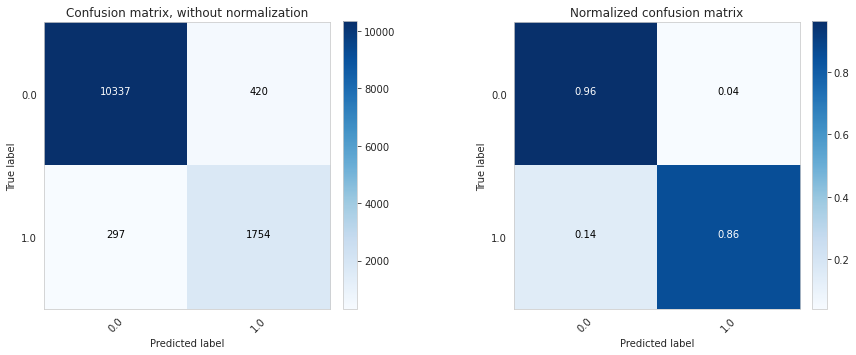

In [58]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [59]:
cm = skm.multilabel_confusion_matrix(targs, (probs > threshold_f1).float(), sample_weight=sample_weight)

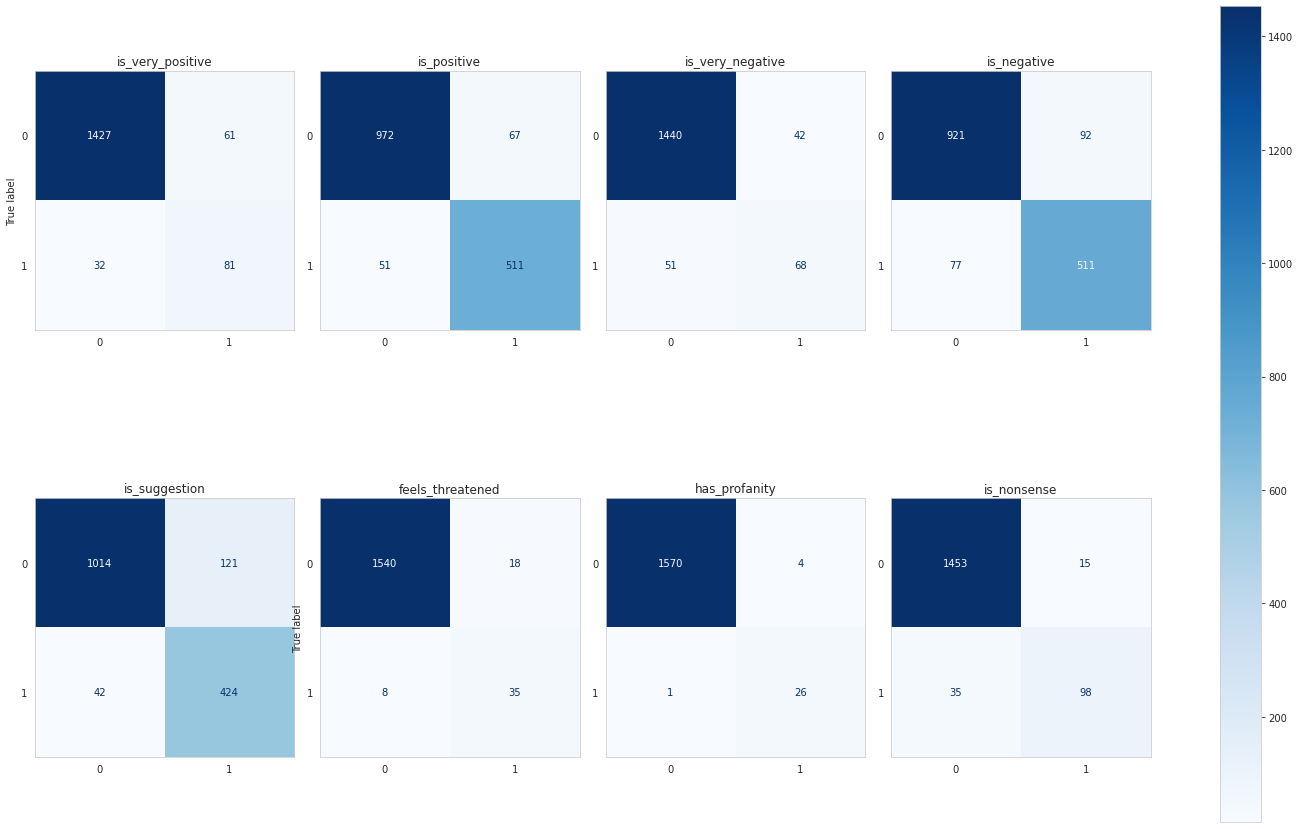

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay

f, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.ravel()
for i in range(8):
    disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g', cmap=plt.cm.Blues)
    disp.ax_.set_title(SENT_LABELS[1:][i][:30])
    disp.ax_.grid(False)
    if i<20:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.10)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [61]:
print(skm.classification_report(eval_targs, (eval_probs > threshold_f1).float(), 
                                labels=[0,1], 
                                sample_weight=sample_weight, 
                                zero_division=1))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     10757
           1       0.81      0.86      0.83      2051

    accuracy                           0.94     12808
   macro avg       0.89      0.91      0.90     12808
weighted avg       0.95      0.94      0.94     12808



In [62]:
classification_report = skm.classification_report(targs, (probs > threshold_f1).float(), 
                                target_names=SENT_LABELS[1:],
                                sample_weight=sample_weight,
                                zero_division=1,
                                output_dict=True)

pd.DataFrame(classification_report).transpose()

,precision,recall,f1-score,support
is_very_positive,0.570423,0.716814,0.635294,113.0
is_positive,0.884083,0.909253,0.896491,562.0
is_very_negative,0.618182,0.571429,0.593886,119.0
is_negative,0.847430,0.869048,0.858102,588.0
is_suggestion,0.777982,0.909871,0.838773,466.0
feels_threatened,0.660377,0.813953,0.729167,43.0
has_profanity,0.866667,0.962963,0.912281,27.0
is_nonsense,0.867257,0.736842,0.796748,133.0
micro avg,0.806808,0.855193,0.830296,2051.0
macro avg,0.761550,0.811272,0.782593,2051.0


#### Raw probability distribution

Useful to see how the threshold can be adjusted to increase sensitivity or specificity

Text(0, 0.5, 'Frequency')

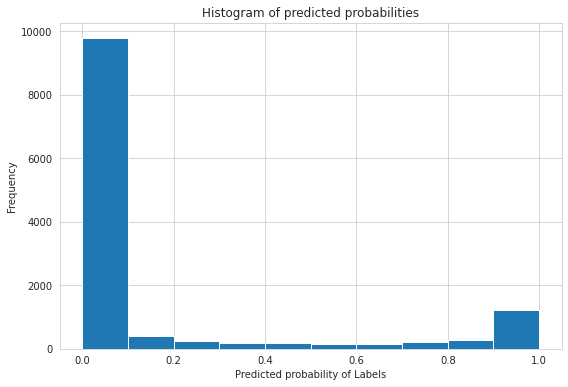

In [63]:
plt.hist(eval_probs, bins=10)
# plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of Labels')
plt.ylabel('Frequency')

#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [64]:
fpr, tpr, thresholds = skm.roc_curve(eval_targs, eval_probs, sample_weight=sample_weight)

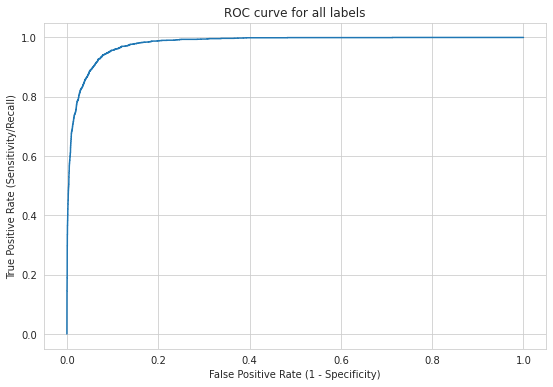

In [65]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [66]:
print(skm.roc_auc_score(eval_targs, eval_probs, average=average, sample_weight=sample_weight))

0.980251767164234


### Let's look at things by label by label

In [67]:
label_metrics = {
    'thresholds': { 'f-beta05': threshold_f05, 'f-beta1': threshold_f1, 'f-beta2': threshold_f2 }
}

for idx, lbl in enumerate(SENT_LABELS[1:]):
    lbl_name, lbl_idx, lbl_targs, lbl_probs = lbl, idx, targs[:,idx], probs[:, idx]
    
    label_metrics[lbl_name] = {}
    label_metrics[lbl_name]['accuracies'] = {}
    label_metrics[lbl_name]['cohen_kappas'] = {}
    label_metrics[lbl_name]['confusion_matrices'] = {}
    label_metrics[lbl_name]['roc'] = {}
    label_metrics[lbl_name]['report'] = {}
    
    # get null accuracy (accuracy we'd get if we simply predicted the most common class)
    u_classes, u_counts = np.unique(lbl_targs, return_counts=True)
    most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
    label_metrics[lbl_name]['null_accuracy'] = most_freq_class_count / len(lbl_targs)
    
    # get raw probability distribution
    label_metrics[lbl_name]['probability_distribution'] = np.histogram(lbl_probs)
    
    # roc/auc curve metrics
    label_metrics[lbl_name]['roc_auc'] = skm.roc_auc_score(lbl_targs, lbl_probs, 
                                                           average=average, sample_weight=sample_weight)
    
    fpr, tpr, thresholds = skm.roc_curve(lbl_targs, lbl_probs, sample_weight=sample_weight)
    label_metrics[lbl_name]['roc']['fpr'] = fpr
    label_metrics[lbl_name]['roc']['tpr'] = tpr
    label_metrics[lbl_name]['roc']['thresholds'] = thresholds
    
    for k,v in label_metrics['thresholds'].items():
        label_metrics[lbl_name]['accuracies'][k] = skm.accuracy_score(lbl_targs, (lbl_probs > v), 
                                                                      sample_weight=sample_weight)
        
        label_metrics[lbl_name]['cohen_kappas'][k] = skm.cohen_kappa_score(lbl_targs, (lbl_probs > v), 
                                                                           sample_weight=sample_weight)
        
        label_metrics[lbl_name]['confusion_matrices'][k] = skm.confusion_matrix(lbl_targs, (lbl_probs > v), 
                                                                                sample_weight=sample_weight)
        
        precision, recall, fbeta_score, support = skm.precision_recall_fscore_support(lbl_targs, 
                                                                                      (lbl_probs > v), 
                                                                                      average=None, 
                                                                                      sample_weight=sample_weight)
        label_metrics[lbl_name]['report'][k] = {}
        label_metrics[lbl_name]['report'][k]['precision'] = precision
        label_metrics[lbl_name]['report'][k]['recall'] = recall
        label_metrics[lbl_name]['report'][k]['fbeta_score'] = fbeta_score
        label_metrics[lbl_name]['report'][k]['support'] = support
          
          

In [68]:
# label_metrics

IS_VERY_POSITIVE

Null Accuracy:	0.929419113054341
AUC Score:	0.9636620991531067

		f-beta05(0.49)		f-beta1(0.42)		f-beta2(0.16)
Accuracy:	0.9450343535290443	0.9419113054341037	0.9250468457214241	
Cohen's Kappa:	0.5877912624199797	0.6041795710901923	0.5968422245445274	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9717              0.9691              0.9704              1488                
1                   0.6068              0.6283              0.6174              113                 
avg/total           0.7893              0.7987              0.7939              1601                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9781              0.959               0.9684              1488                
1                   0.5704              0.7168              0.6353              1

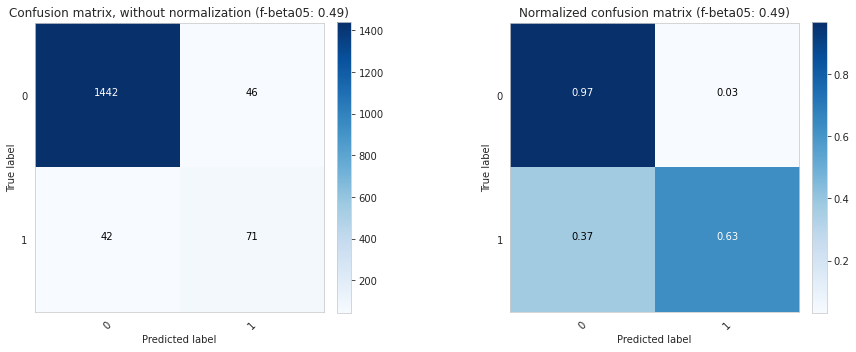

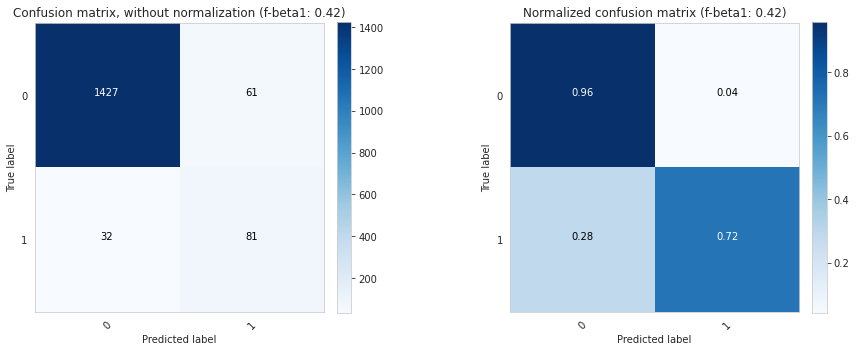

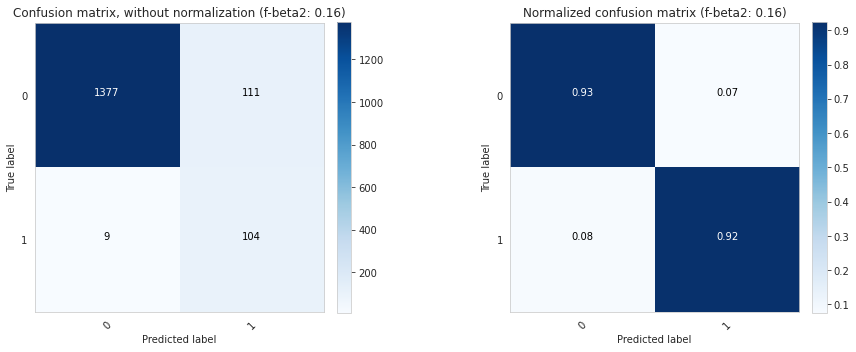



ROC Curve:


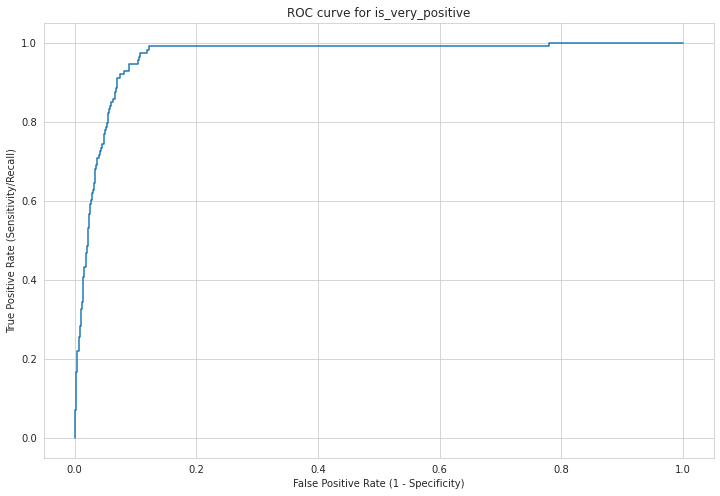

Predicted Probability Distribution:


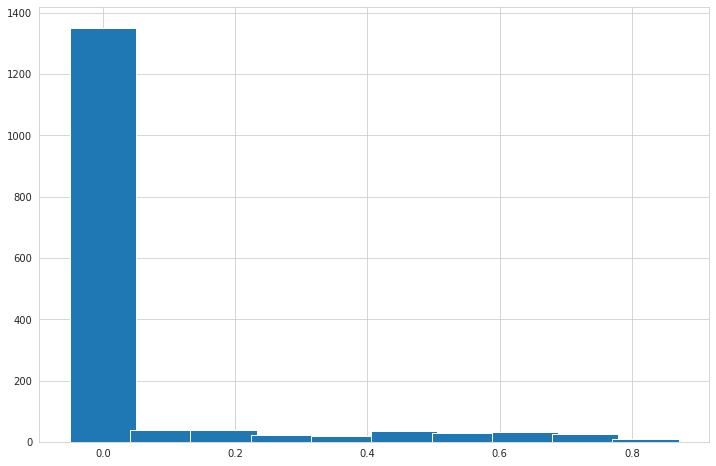



----------------------------------------------------------------------------------------------------


IS_POSITIVE

Null Accuracy:	0.6489693941286696
AUC Score:	0.977257080617484

		f-beta05(0.49)		f-beta1(0.42)		f-beta2(0.16)
Accuracy:	0.924422236102436	0.9262960649594004	0.9181761399125546	
Cohen's Kappa:	0.8339161783428569	0.8392827367482569	0.8256102945395072	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9405              0.9432              0.9419              1039                
1                   0.8945              0.8897              0.8921              562                 
avg/total           0.9175              0.9164              0.917               1601                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9501              0.9355              0.9428              103

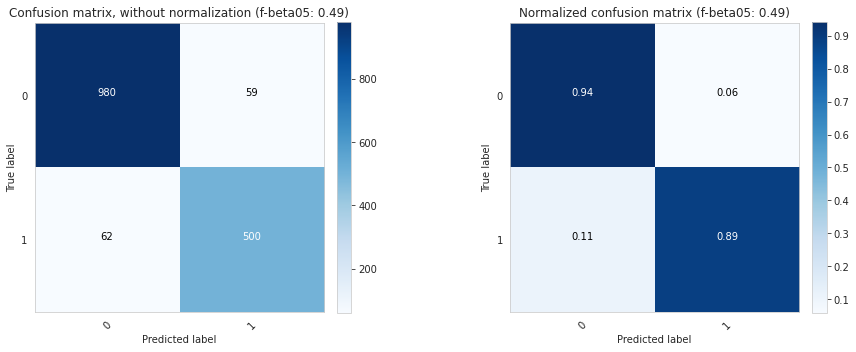

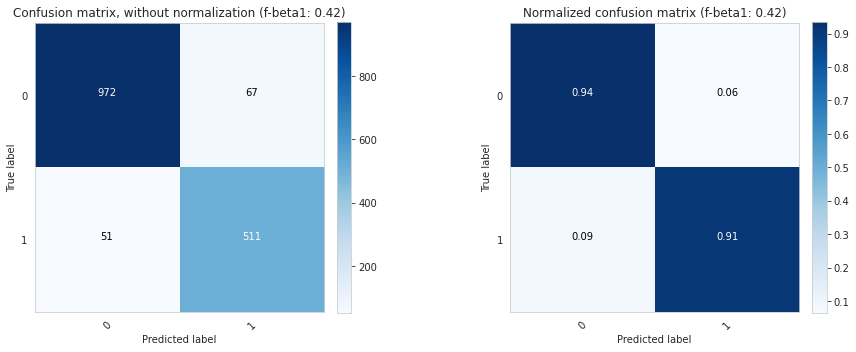

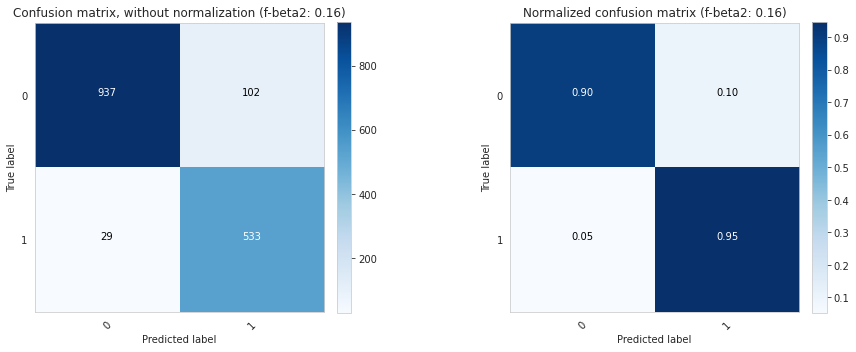



ROC Curve:


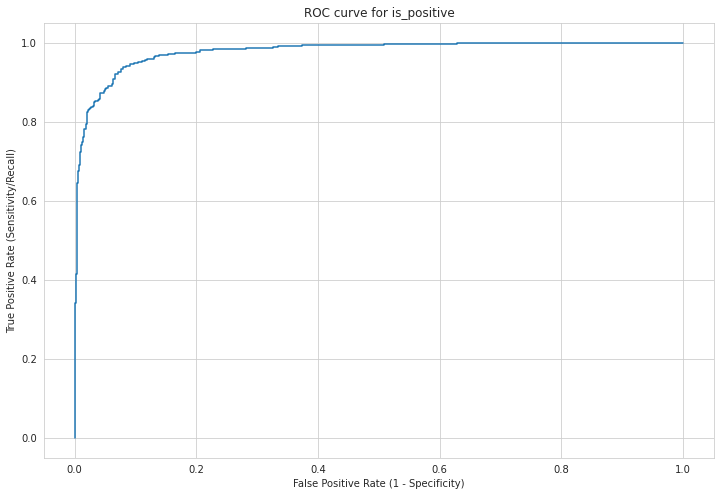

Predicted Probability Distribution:


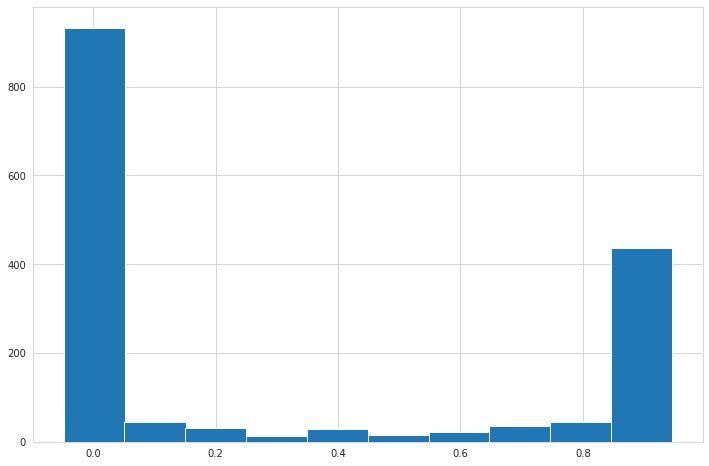



----------------------------------------------------------------------------------------------------


IS_VERY_NEGATIVE

Null Accuracy:	0.9256714553404123
AUC Score:	0.9554599167602263

		f-beta05(0.49)		f-beta1(0.42)		f-beta2(0.16)
Accuracy:	0.94316052467208	0.9419113054341037	0.905683947532792	
Cohen's Kappa:	0.5348144411202183	0.5626569618356934	0.5280024678486568	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9603              0.9791              0.9696              1482                
1                   0.6556              0.4958              0.5646              119                 
avg/total           0.8079              0.7374              0.7671              1601                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9658              0.9717              0.9687             

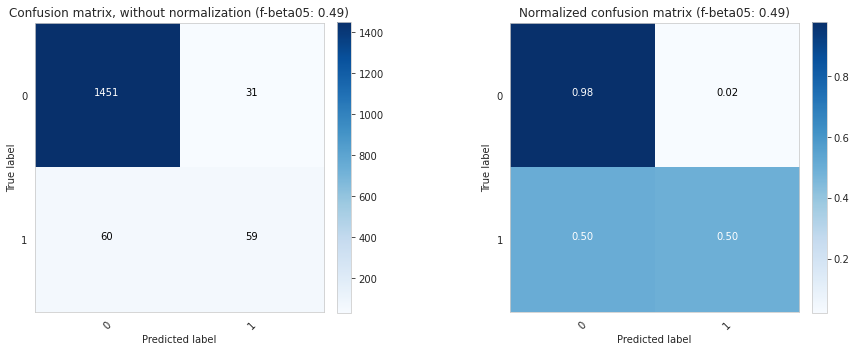

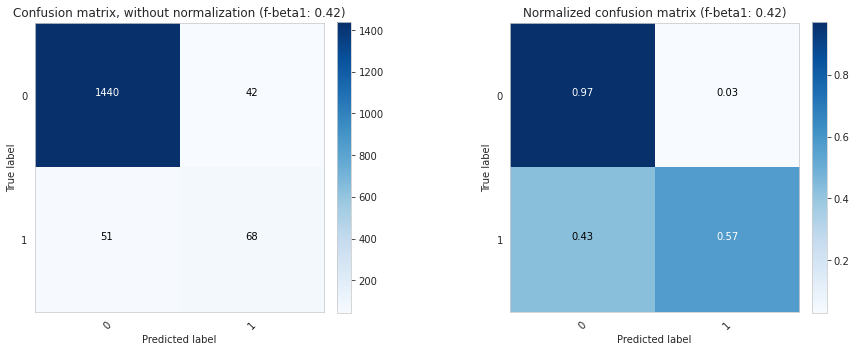

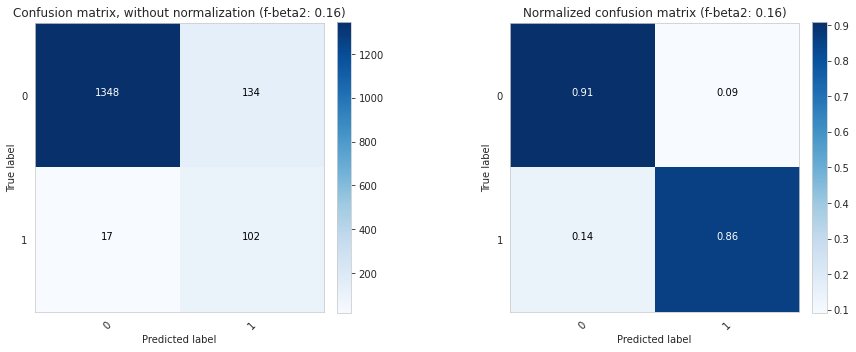



ROC Curve:


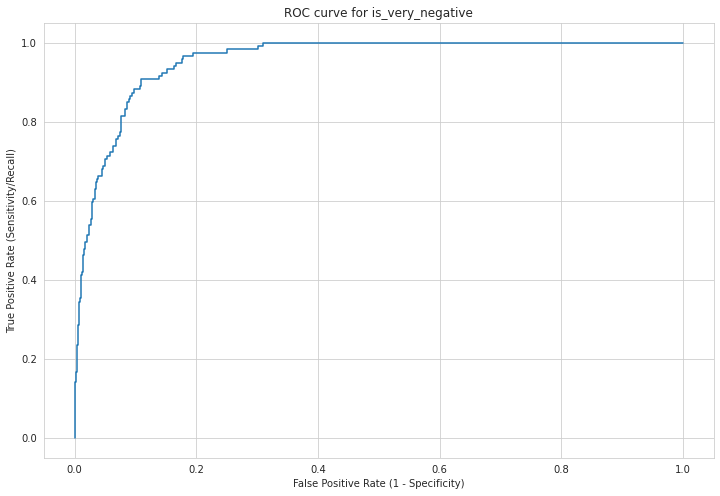

Predicted Probability Distribution:


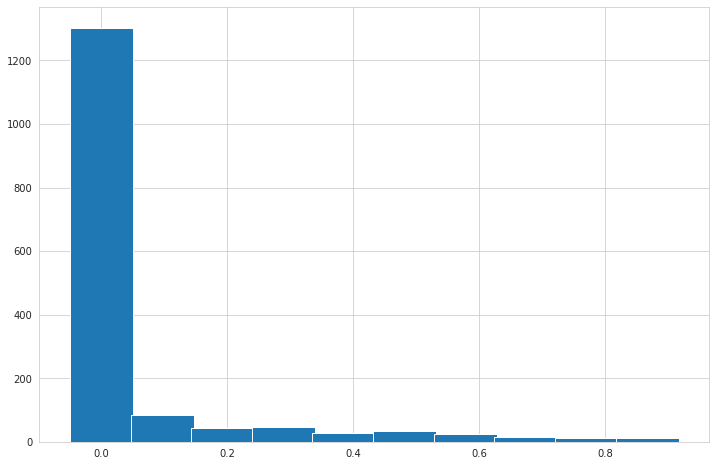



----------------------------------------------------------------------------------------------------


IS_NEGATIVE

Null Accuracy:	0.6327295440349782
AUC Score:	0.9605250787383068

		f-beta05(0.49)		f-beta1(0.42)		f-beta2(0.16)
Accuracy:	0.9031855090568395	0.8944409743910057	0.8363522798251093	
Cohen's Kappa:	0.7899684557004452	0.7740858655565046	0.6735165646005411	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9141              0.9348              0.9244              1013                
1                   0.8832              0.8486              0.8656              588                 
avg/total           0.8986              0.8917              0.895               1601                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9228              0.9092              0.916               1

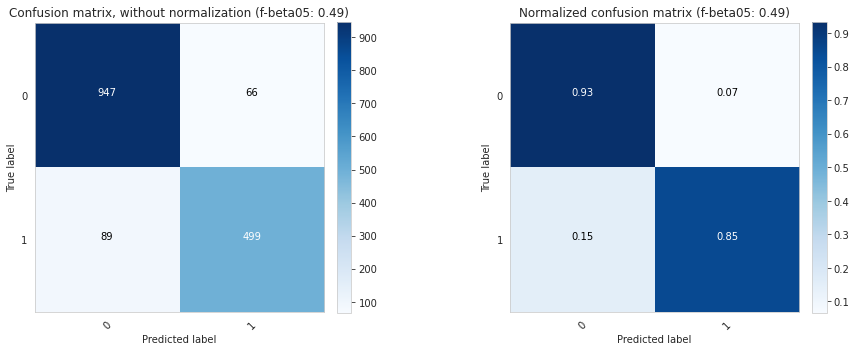

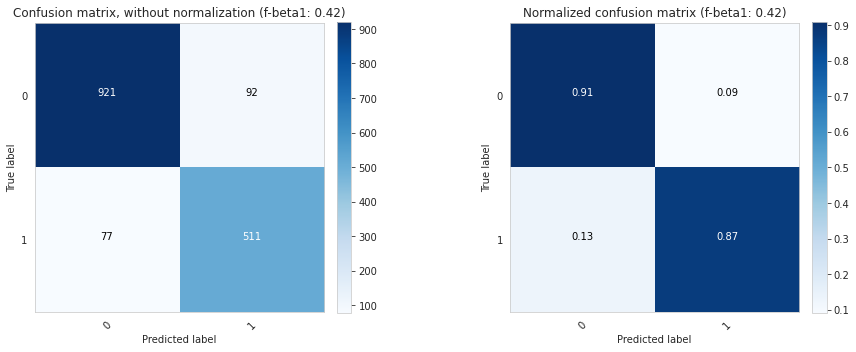

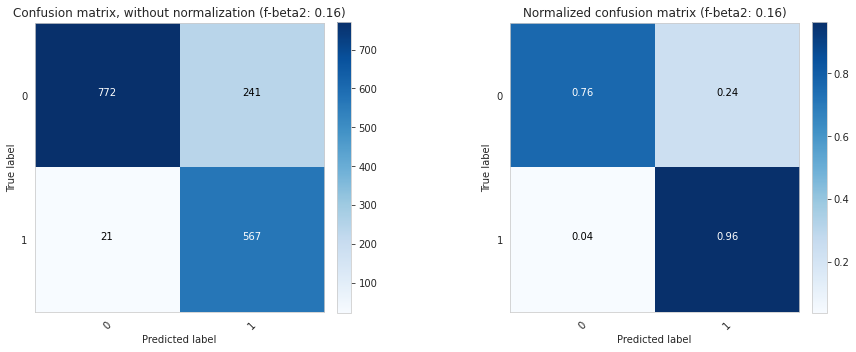



ROC Curve:


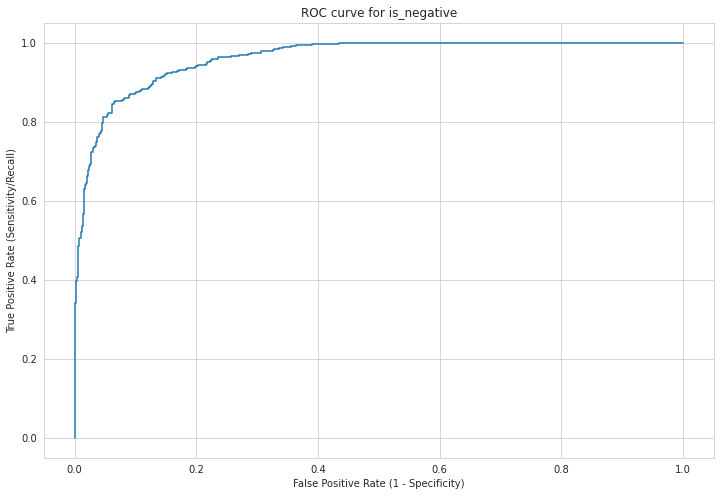

Predicted Probability Distribution:


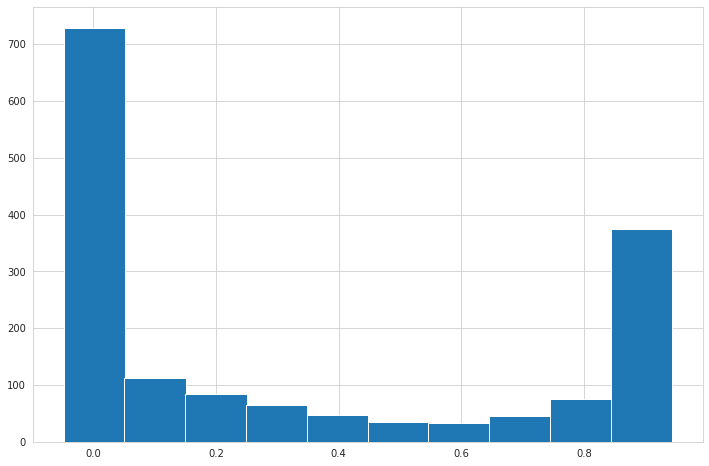



----------------------------------------------------------------------------------------------------


IS_SUGGESTION

Null Accuracy:	0.7089319175515303
AUC Score:	0.9600253351231779

		f-beta05(0.49)		f-beta1(0.42)		f-beta2(0.16)
Accuracy:	0.9025608994378513	0.8981886321049344	0.8713304184884447	
Cohen's Kappa:	0.7719714704131531	0.7650402324360679	0.717519631086322	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9537              0.9066              0.9295              1135                
1                   0.7969              0.8927              0.8421              466                 
avg/total           0.8753              0.8997              0.8858              1601                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9602              0.8934              0.9256              

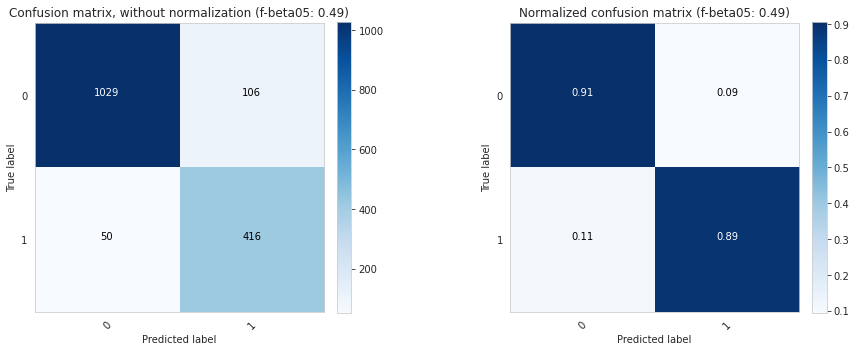

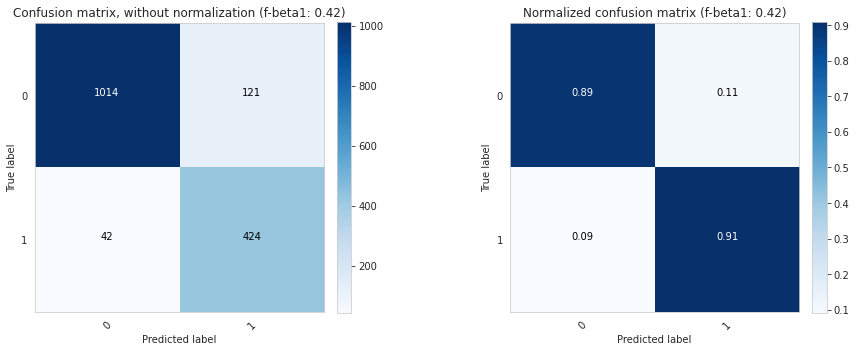

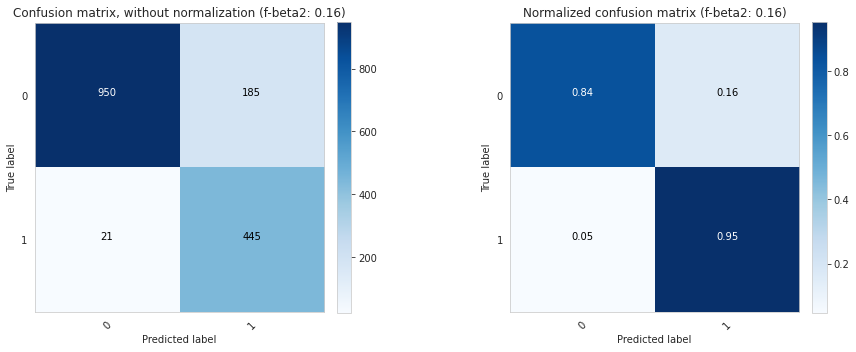



ROC Curve:


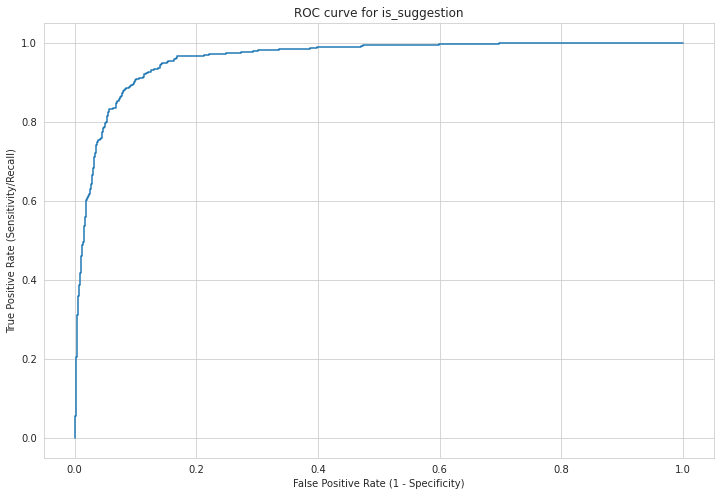

Predicted Probability Distribution:


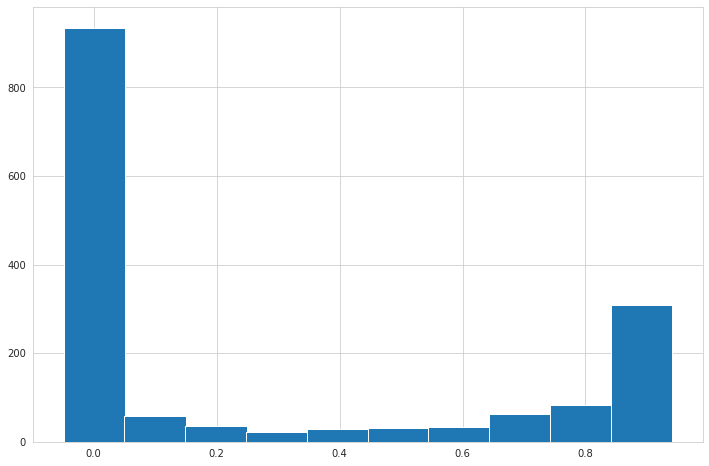



----------------------------------------------------------------------------------------------------


FEELS_THREATENED

Null Accuracy:	0.9731417863835103
AUC Score:	0.9923575245544378

		f-beta05(0.49)		f-beta1(0.42)		f-beta2(0.16)
Accuracy:	0.9831355402873204	0.9837601499063086	0.9762648344784509	
Cohen's Kappa:	0.7010436189857047	0.7208893776234092	0.6665826336672731	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9936              0.9891              0.9913              1558                
1                   0.66                0.7674              0.7097              43                  
avg/total           0.8268              0.8783              0.8505              1601                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9948              0.9884              0.9916          

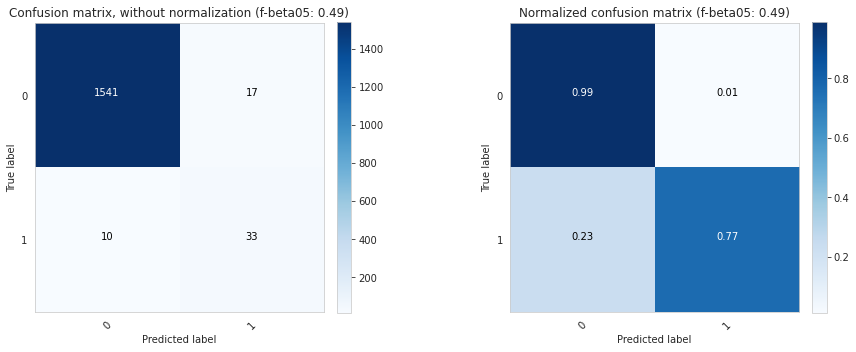

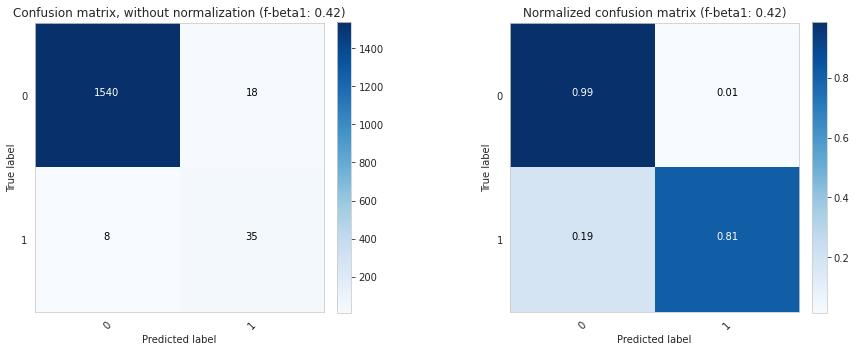

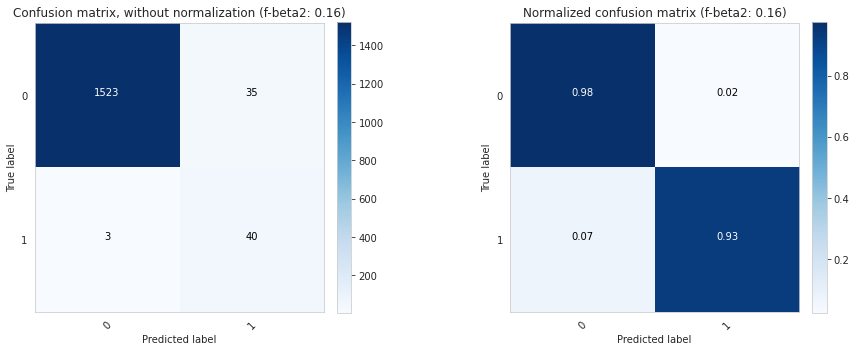



ROC Curve:


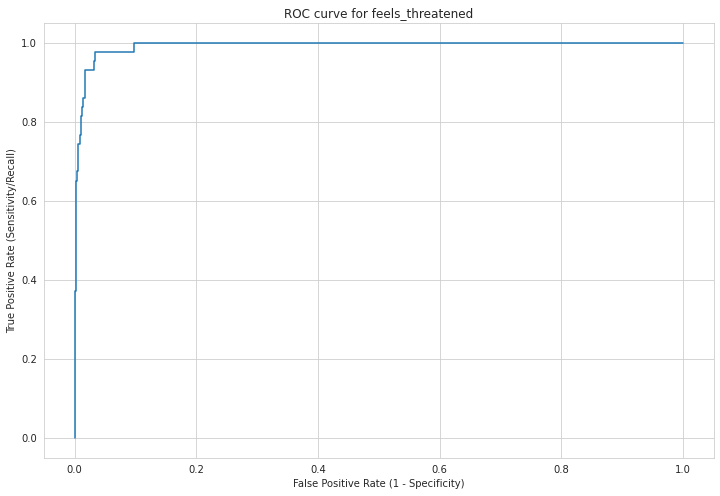

Predicted Probability Distribution:


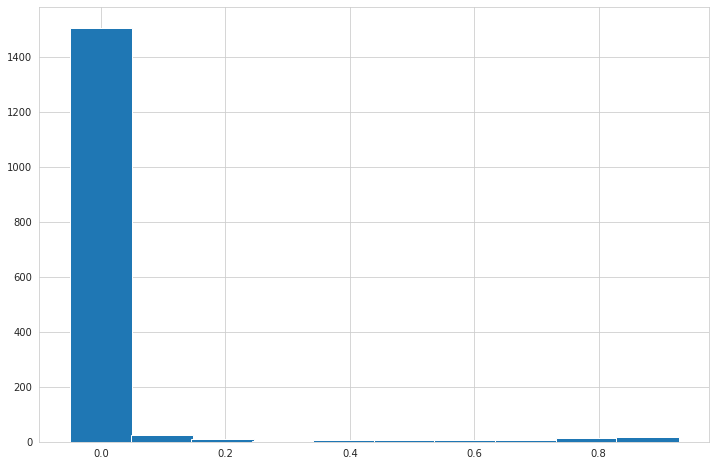



----------------------------------------------------------------------------------------------------


HAS_PROFANITY

Null Accuracy:	0.9831355402873204
AUC Score:	0.999623511694668

		f-beta05(0.49)		f-beta1(0.42)		f-beta2(0.16)
Accuracy:	0.9968769519050593	0.9968769519050593	0.9968769519050593	
Cohen's Kappa:	0.9106953601749278	0.9106953601749278	0.913675038552372	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9994              0.9975              0.9984              1574                
1                   0.8667              0.963               0.9123              27                  
avg/total           0.933               0.9802              0.9553              1601                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9994              0.9975              0.9984              1

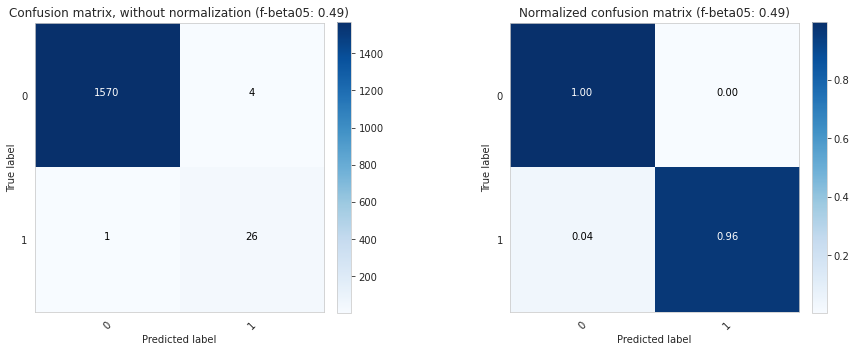

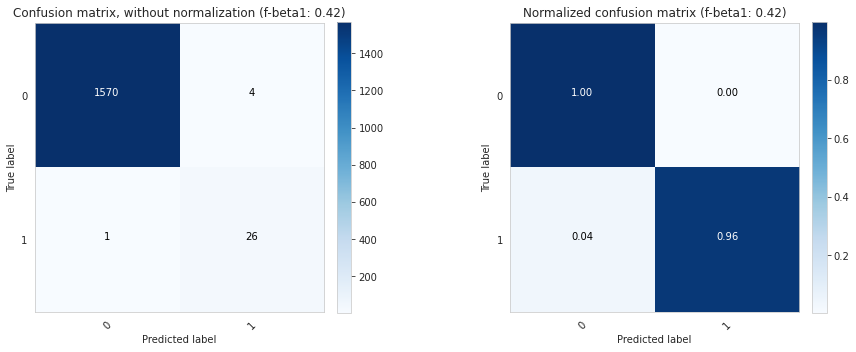

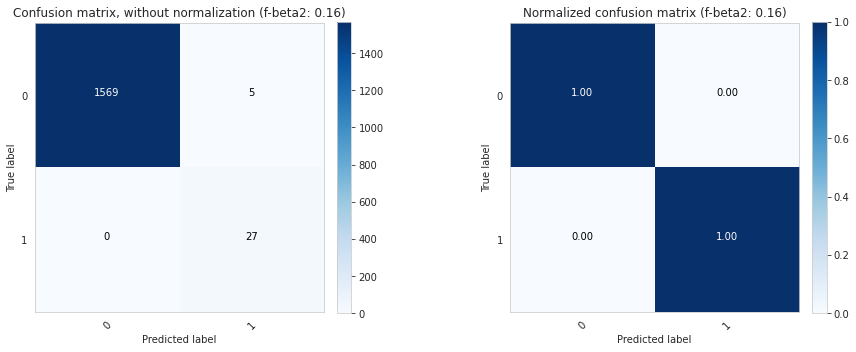



ROC Curve:


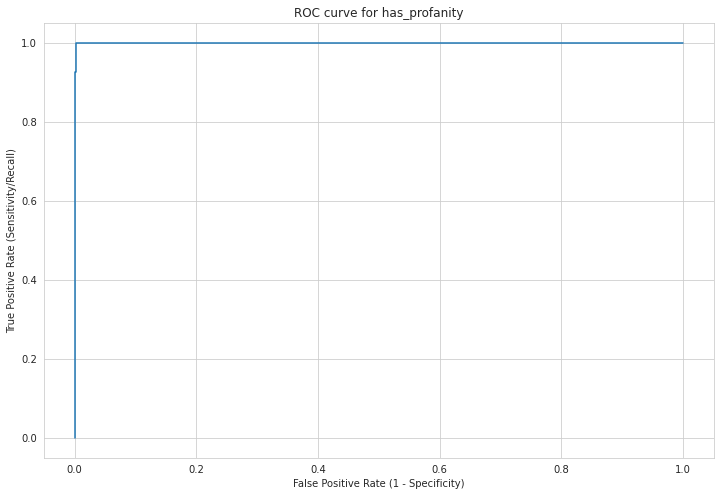

Predicted Probability Distribution:


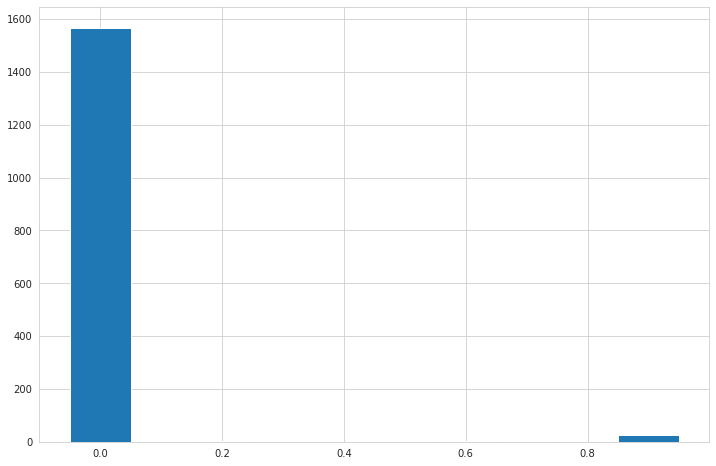



----------------------------------------------------------------------------------------------------


IS_NONSENSE

Null Accuracy:	0.9169269206745784
AUC Score:	0.9786805228329679

		f-beta05(0.49)		f-beta1(0.42)		f-beta2(0.16)
Accuracy:	0.966895690193629	0.9687695190505934	0.9656464709556527	
Cohen's Kappa:	0.7641550601334693	0.7799542590739661	0.7812314442376826	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9745              0.9898              0.9821              1468                
1                   0.8636              0.7143              0.7819              133                 
avg/total           0.9191              0.852               0.882               1601                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9765              0.9898              0.9831              14

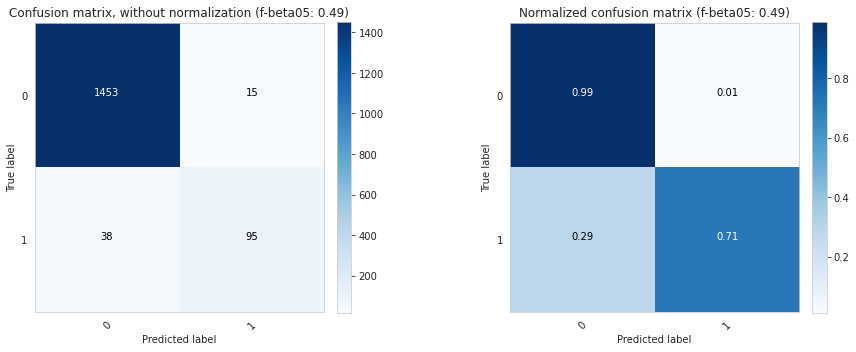

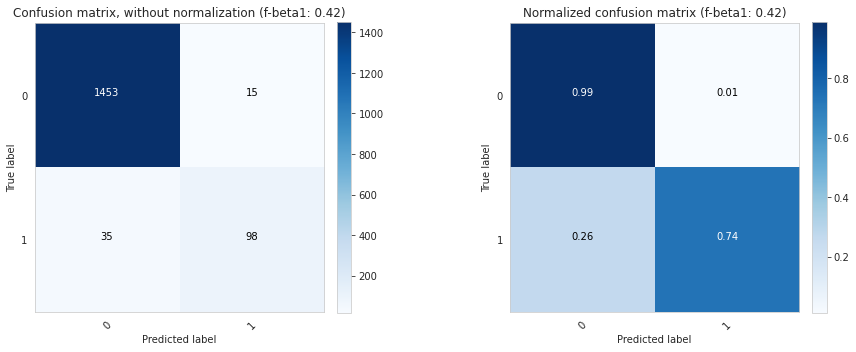

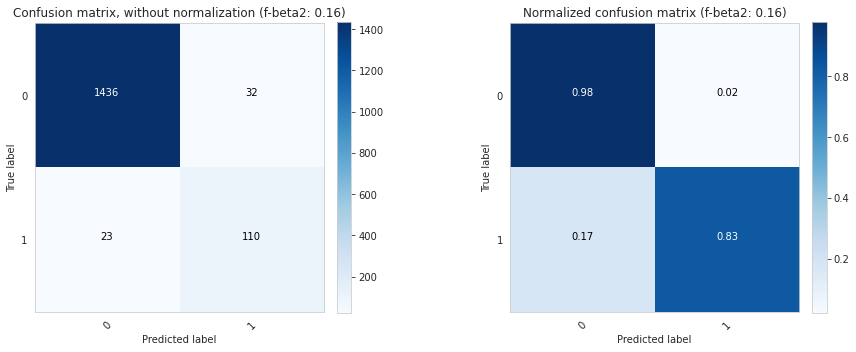



ROC Curve:


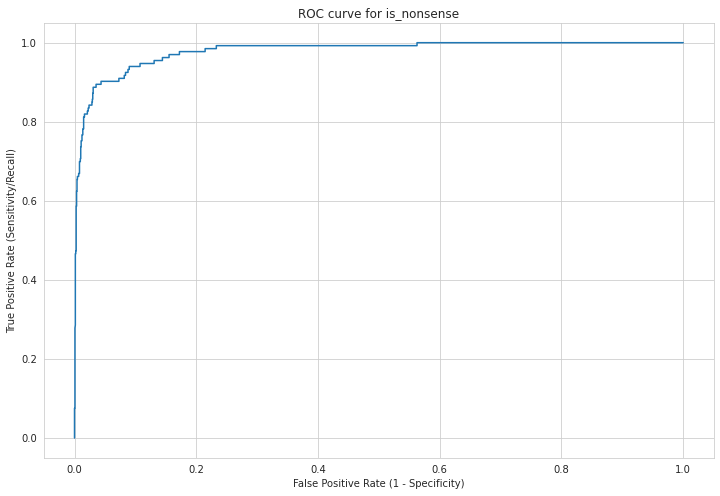

Predicted Probability Distribution:


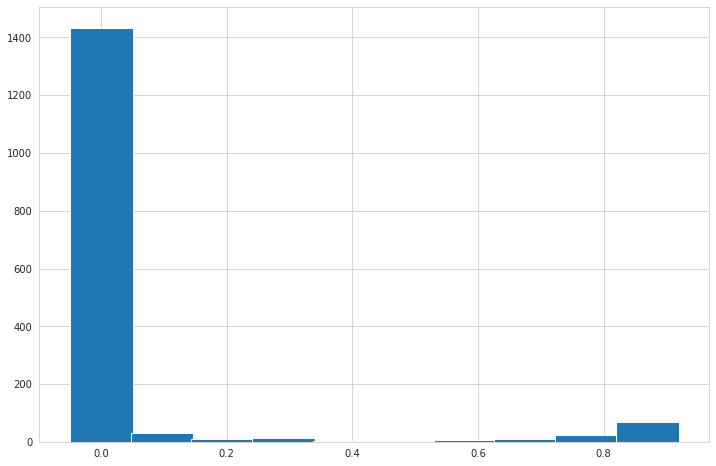



----------------------------------------------------------------------------------------------------




In [69]:
for lbl in label_metrics.keys():
    if (lbl == 'thresholds'): continue
    
    print(f'{lbl.upper()}\n')
    
    print(f'Null Accuracy:\t{label_metrics[lbl]["null_accuracy"]}')
    print(f'AUC Score:\t{label_metrics[lbl]["roc_auc"]}')
    print('')
    
    print(''.join([ f'\t\t{threshold}({np.round(v, 4)})' for threshold, v in label_metrics['thresholds'].items() ]))
    
    print('Accuracy:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["accuracies"][threshold]}\t', end='')
    print('')
    
    print('Cohen\'s Kappa:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["cohen_kappas"][threshold]}\t', end='')
    print('\n')
    
    print('Classification Reports:')
    for k in label_metrics[lbl]['report'].keys():
        print(f'{k}')
        print(f'{"":<20}' + ''.join([ f'{sub_key:<20}' for sub_key in label_metrics[lbl]['report'][k].keys() ]))
        
        for i in range(2):
            print(f'{i:<20}' + ''.join([ f'{np.round(v[i],4):<20}' 
                                      for v in label_metrics[lbl]['report'][k].values() ]))
        
        print(f'{"avg/total":<20}' + ''.join([ f'{ np.round(v.mean(),4) if (sub_key != "support") else np.round(v.sum(),4):<20}' 
                                     for sub_key, v in label_metrics[lbl]['report'][k].items() ]))
        print('')
    print('\n')
    
    print('Confusion Matrices:')
    for threshold, v in label_metrics['thresholds'].items():
        cm = label_metrics[lbl]['confusion_matrices'][threshold]
        
        # Plot non-normalized confusion matrix
        fig = plt.figure(figsize=(12,8))
        plt.subplot(1, 2, 1)
        plot_confusion_matrix(cm, classes=[0,1], 
                              title=f'Confusion matrix, without normalization ({threshold}: {np.round(v,4)})')

        # Plot normalized confusion matrix
        plt.subplot(1, 2, 2)
        plot_confusion_matrix(cm, classes=[0,1], normalize=True, 
                              title=f'Normalized confusion matrix ({threshold}: {np.round(v,4)})')

        fig.subplots_adjust(wspace=0.5)
        plt.show()
    print('\n')
    
    print('ROC Curve:')
    plt.figure(figsize=(12,8))
    plt.plot(label_metrics[lbl]['roc']['fpr'], label_metrics[lbl]['roc']['tpr'])
    plt.xlim = ([0.0, 1.0])
    plt.ylim = ([0.0, 1.0])
    plt.title(f'ROC curve for {lbl}')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.grid(True)
    plt.show()
    
    print('Predicted Probability Distribution:')
    plt.figure(figsize=(12,8))
    plt.xlim = ([0.0, 1.0])
    plt.bar(label_metrics[lbl]['probability_distribution'][1][:-1], 
            label_metrics[lbl]['probability_distribution'][0], width=0.1)
    plt.show()
    
    print('\n')
    print('-'*100)
    print('\n')
        

## Ensemble forwards and backwards (optional) passes

In [26]:
try:
    inf_learn.purge(); inf_learn = None;
    gc.collect()
    torch.cuda.empty_cache()
except: pass

inf_learn = load_learner(fname=SENTIMENT_CLS_PATH/f'{m_pre}export_clas{m_suf}.pkl')
dls = get_sentiment_train_dls(df, hf_arch, hf_tokenizer)
inf_learn.dls = dls

In [27]:
# inf_learn.loss_func = inf_learn.loss_func.to('cuda:1')

In [28]:
probs, targs, loss = inf_learn.get_preds(with_loss=True, reorder=True)
probs.shape, targs.shape, loss.shape

(torch.Size([1601, 8]), torch.Size([1601, 8]), torch.Size([1601]))

### Results

In [29]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [30]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

print(threshold_f05, threshold_f1, threshold_f2)

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

print('Fowards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs, targs, sigmoid=False)}')

0.49000000000000005 0.42000000000000004 0.16000000000000003
Fowards Only
-------------
f05:	Optimal threshold = 0.49000000000000005	(Accuracy = 0.9456589818000793)
f1:	Optimal threshold = 0.42000000000000004	(Accuracy = 0.9440193772315979)
f2:	Optimal threshold = 0.16000000000000003	(Accuracy = 0.9244222640991211)

Accuracy: 0.9464397430419922


In [31]:
final_valid_loss = loss.mean().item()

## Codify our training/eval loop and score reporting

In [32]:
#export
def train(hf_arch, hf_config, hf_tokenizer, hf_model, train_config={}):
          
    config = {**sentiment_train_config, **train_config}    
    m_pre, m_suf = config['m_pre'], config['m_suf']
    
    df = get_sentiment_train_data(train_config=config)
    train_df, valid_df = df[df.is_valid == False], df[df.is_valid == True]
    
    dls = get_sentiment_train_dls(df, hf_arch, hf_tokenizer, train_config=config)
    
    learn, fit_cbs = get_learner(hf_model, dls, train_df=None, use_weighted_loss=False, train_config=config)
    
    with learn.no_logging(): 
        lr_min, lr_steep = learn.lr_find()
        learn.fit_one_cycle(3, lr_max=lr_min, cbs=fit_cbs)
        
        learn.unfreeze()
        lr_min, lr_steep = learn.lr_find()
        learn.fit_one_cycle(5, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs)
        
        # export model for inference (SavedModelCallback already saves the best model)
        learn.export(fname=config['export_filename'])
        
    # ===== fetch scores, probs, targs, losses, and optional f-scores/thresholds ====
    learn = learn.load(config['save_model_filename'])
    scores = dict(zip(learn.recorder.metric_names[2:], learn.validate()))
    probs, targs, losses = learn.get_preds(dl=dls.valid, with_loss=True)
    
    # determine optimal threshold based on desired f-score
    average, sample_weight = config['opt_beta_average'], config['opt_beta_sample_weight']

    f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                       average=average, sample_weight=sample_weight)
    f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                       average=average, sample_weight=sample_weight)
    f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                       average=average, sample_weight=sample_weight)

    scores['f05'], scores['f1'], scores['f2'] = {}, {}, {}
    
    scores['f05']['threshold'] = f05.opt_th(probs, targs)
    scores['f1']['threshold'] = f1.opt_th(probs, targs)
    scores['f2']['threshold'] = f2.opt_th(probs, targs)
    
    scores['f05']['score'] = f05.opt_fscore(probs, targs)
    scores['f1']['score'] = f1.opt_fscore(probs, targs)
    scores['f2']['score'] = f2.opt_fscore(probs, targs)
    
    # save scores from validation set
    yyyymmdd = datetime.today().strftime("%Y%m%d")
          
    with open(f"{config['learner_path']}/{m_pre}model_scores{m_suf}.pkl", 'wb') as f:
        pickle.dump(scores, f)
        
    # save train/validation probs, targs, losses for review
    test_dl = dls.test_dl(df, with_labels=True)
    probs, targs, losses = learn.get_preds(dl=test_dl, with_loss=True)
    
    probs_df = pd.DataFrame(probs.numpy(), columns=['prob_' + lbl for lbl in SENT_LABELS[1:]])
    targs_df = pd.DataFrame(targs.numpy(), columns= ['targ_' + lbl for lbl in SENT_LABELS[1:]])
    losses_df = pd.DataFrame(losses.numpy(), columns=['loss'])
    final_df = pd.concat([df.reset_index(), probs_df, targs_df, losses_df], axis=1)
    
    final_df.to_csv(f"{config['learner_path']}/{yyyymmdd}_train_results{m_suf}.csv", index=False)
        
    return scores, final_df

In [33]:
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = "facebook/bart-base" #"roberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(SENT_LABELS[1:])

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartForSequenceClassification: ['final_logits_bias']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.weight', 'classification_head.dense.bias', 'classification_head.out_proj.weight', 'classification_head.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to u

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with fbeta_score value: 0.7816713295782611.
Better model found at epoch 1 with fbeta_score value: 0.8191106308881719.
Better model found at epoch 2 with fbeta_score value: 0.8312868794602417.


Better model found at epoch 0 with fbeta_score value: 0.8342137030596852.
Better model found at epoch 2 with fbeta_score value: 0.834489927635241.


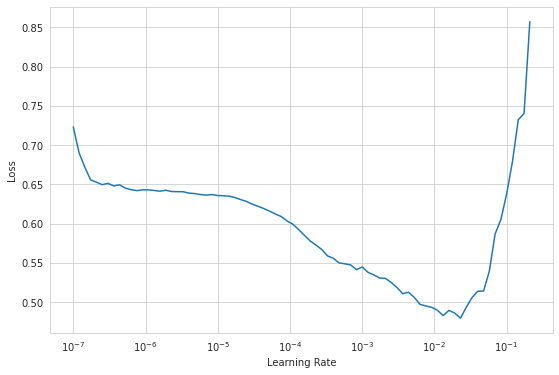

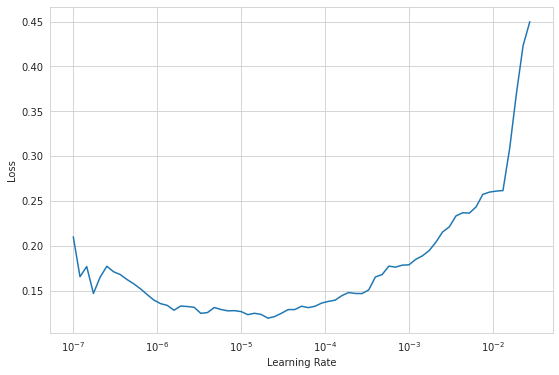

In [34]:
scores, train_res_df = train(hf_arch, hf_config, hf_tokenizer, hf_model, train_config={})

In [35]:
scores

{'valid_loss': 0.12755295634269714,
 'accuracy_multi': 0.9443316459655762,
 'fbeta_score': 0.833351664041203,
 'precision_score': 0.8143940094120141,
 'recall_score': 0.856167723061921,
 'roc_auc_score': 0.8939591062351303,
 'opt_th': 0.4199999999999999,
 'f05': {'threshold': 0.49000000000000005, 'score': 0.8319035694829875},
 'f1': {'threshold': 0.45000000000000007, 'score': 0.834489927635241},
 'f2': {'threshold': 0.19, 'score': 0.8813497612837818}}

In [36]:
train_res_df.head()

,index,id,question_ans_id,answer_text,answer_text_non_english,language,survey_id,survey_type_id,benchmark_survey_type,client_id,rsp_id,question_category_abbr,question_text,question_class,question_category_id,question_report_abbr,question_category_label,benchmark_level1,benchmark_level2,benchmark_level3,client_benchmark_level,group_code,group_id,group_level1_code,group_level1_name,group_level2_code,group_level2_name,group_level3_code,group_level3_name,group_level4_code,group_level4_name,group_level5_code,group_level5_name,group_level6_code,group_level6_name,group_level7_code,group_level7_name,group_level8_code,group_level8_name,overall_sentiment,is_very_positive,is_positive,is_very_negative,is_negative,is_suggestion,feels_threatened,has_profanity,is_nonsense,labels,is_valid,prob_is_very_positive,prob_is_positive,prob_is_very_negative,prob_is_negative,prob_is_suggestion,prob_feels_threatened,prob_has_profanity,prob_is_nonsense,targ_is_very_positive,targ_is_positive,targ_is_very_negative,targ_is_negative,targ_is_suggestion,targ_feels_threatened,targ_has_profanity,targ_is_nonsense,loss
0,0,19309,1877,Our department had an MSO who was great at finances but lacked leadership skills. Many members ...,NaN,English,118,9,SAW,UCSD,88342,None,"59. If you would like to elaborate on your responses above, or if you have any additional feedba...",Verbatim,201.0,Comments re Work Environment at UCSD,Other,None,None,None,1.0,NaN,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,0,0,1,0,0,0,0,is_negative,False,0.005865,0.053700,0.437223,0.977543,0.009936,0.123049,0.000707,0.003992,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.100583
1,1,305515,24623,Just tell us what's wrong.. but we have no funding to correct issues.,NaN,English,129,22,CSS,CALPOLYSLO,181859,EH&S,Let us know your suggestions on how the EH&S can better meet the needs of the Campus.,Verbatim-Dept-Improve,325.0,EHS_Improve,"Environmental, Health and Safety",Safety,"Safety, Risk & Sustainability","Env, Health & Safety",1.0,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,0,0,1,0,0,0,0,is_negative,False,0.000532,0.018654,0.061876,0.917303,0.514903,0.000517,0.000384,0.008062,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.112745
2,2,276058,8462,Appealing layout,NaN,English,108,7,CSS-STUDENT-ONLY,UCSD,171304,Bookstore,Let us know what you like about the Campus Bookstore,Verbatim-Dept-Like,14.0,Bookstore-Like,Campus Bookstore,Auxiliary Services,"Dining, Catering, & Retail Services",Bookstore,1.0,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0,1,0,0,0,0,0,0,is_positive,False,0.005080,0.972623,0.000059,0.006904,0.029424,0.000021,0.000040,0.006590,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009547
3,3,40899,9440,"Shirley Balbin Stacher is a great boss, in EM / Admissions",NaN,English,140,9,SAW,UCSD,230696,None,60. Would you like to highlight a colleague or manager who has made a particular impact on creat...,Verbatim,201.0,Highlight Colleague or Manager,Other,None,None,None,1.0,30101.0,3547,999999.0,UC San Diego,10000.0,ACADEMIC AFFAIRS,30100.0,ENROLLMENT MANAGEMENT,30101.0,ADMISSIONS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0,1,0,0,0,0,0,0,is_positive,False,0.338186,0.977197,0.000330,0.003511,0.001245,0.000055,0.000013,0.001904,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055363
4,4,120692,1898,They do not understand student needs: they police unnecessary things,NaN,English,53,7,CSS-STUDENT-ONLY,UCSD,106796,Police,Any additional comments for POLICE/PUBLIC SAFETY?,Verbatim-Dept-Question,13.0,Police-Comments,Police/Public Safety,Safety,Police - Security,Police - Security,1.0,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,0,0,1,0,0,0,0,is_negative,False,0.000434,0.009746,0.094010,0.963984,0.006564,0.006667,0.000017,0.007548,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.020813


In [37]:
# load results
with open(SENTIMENT_CLS_PATH/'model_scores_multilabel_hf.pkl', 'rb') as f: training_results = pickle.load(f)
training_results

{'valid_loss': 0.12755295634269714,
 'accuracy_multi': 0.9443316459655762,
 'fbeta_score': 0.833351664041203,
 'precision_score': 0.8143940094120141,
 'recall_score': 0.856167723061921,
 'roc_auc_score': 0.8939591062351303,
 'opt_th': 0.4199999999999999,
 'f05': {'threshold': 0.49000000000000005, 'score': 0.8319035694829875},
 'f1': {'threshold': 0.45000000000000007, 'score': 0.834489927635241},
 'f2': {'threshold': 0.19, 'score': 0.8813497612837818}}

In [38]:
inf_learn = load_learner(SENTIMENT_CLS_PATH/'export_clas_multilabel_hf.pkl')
print(inf_learn.loss_func.thresh)
print(inf_learn.blurr_predict('We are not paid enough and the benefits are horrible'))
print(inf_learn.blurr_predict("The faculty really support us well!!!  It's great working and I feel valued"))

0.4199999999999999


((#2) ['is_very_negative','is_negative'], tensor([False, False,  True,  True, False, False, False, False]), tensor([9.5719e-04, 1.2103e-02, 4.7037e-01, 9.8346e-01, 3.5381e-03, 8.6545e-04,
        2.7675e-03, 4.6659e-03]))


((#2) ['is_very_positive','is_positive'], tensor([ True,  True, False, False, False, False, False, False]), tensor([4.4453e-01, 9.9396e-01, 5.8096e-04, 4.2488e-03, 1.5710e-03, 6.5234e-05,
        6.6553e-05, 2.5607e-03]))


## Inference

### Inference (ad-hoc documents)

In [39]:
print(SENT_LABELS[1:])

['is_very_positive', 'is_positive', 'is_very_negative', 'is_negative', 'is_suggestion', 'feels_threatened', 'has_profanity', 'is_nonsense']


In [40]:
test_comments = [
    'Not paid enough.',
    'I am satisfied with my benefits and we have enough people in my department. The faculty is mean to me.',
    'I love cats',
    "I can never find a parking spot. The shuttles are not on time. Help",
    "I was really uncomfortable to express my opinion!!!",
    "Jeff Wadell is an exceptional leader.  He has gone above and beyond to create a positive working environment and provide growth opportunities.  His commitment to his team is unrivaled and commendable.\\r\\n\\r\\nNikki Panza is a model of authentic leadership for Building and Custodial Services.  She has earned the respect of those she leads through honest communication, empathy, and ethical consultation."
]

for c in test_comments: print(inf_learn.blurr_predict(c, with_input=True))

(HF_BaseInput([   0, 1491, 1199,  615,    4,    2]), (#1) ['is_negative'], tensor([False, False, False,  True, False, False, False, False]), tensor([3.2438e-04, 1.4903e-02, 3.5090e-02, 9.5736e-01, 2.2459e-03, 3.6137e-05,
        9.5403e-04, 2.3733e-02]))


(HF_BaseInput([    0,    38,   524, 10028,    19,   127,  1795,     8,    52,    33,
          615,    82,    11,   127,  1494,     4,    20,  7998,    16,  1266,
            7,   162,     4,     2]), (#2) ['is_positive','is_negative'], tensor([False,  True, False,  True, False, False, False, False]), tensor([5.1867e-02, 7.0481e-01, 1.6505e-01, 8.7131e-01, 3.0016e-03, 5.2910e-03,
        2.1207e-04, 5.1489e-03]))


(HF_BaseInput([    0,    38,   657, 10017,     2]), (#1) ['is_positive'], tensor([False,  True, False, False, False, False, False, False]), tensor([2.1437e-01, 9.8493e-01, 3.1052e-04, 3.6805e-03, 1.9550e-03, 3.0280e-05,
        3.5911e-05, 1.0559e-02]))


(HF_BaseInput([    0,    38,    64,   393,   465,    10,  2932,  1514,     4,    20,
         2572,    90,  1634,    32,    45,    15,    86,     4, 10310,     2]), (#1) ['is_negative'], tensor([False, False, False,  True, False, False, False, False]), tensor([7.6726e-04, 1.8385e-02, 1.4066e-01, 9.6672e-01, 1.4592e-01, 1.1113e-03,
        1.6498e-04, 4.0825e-03]))


(HF_BaseInput([    0,    38,    21,   269,  9800,     7,  5486,   127,  2979, 16506,
            2]), (#2) ['is_negative','feels_threatened'], tensor([False, False, False,  True, False,  True, False, False]), tensor([3.2400e-03, 1.5467e-02, 1.3697e-01, 9.5832e-01, 7.0885e-03, 8.1103e-01,
        2.0296e-05, 1.1407e-02]))


(HF_BaseInput([    0,  2321,  8914,   890,    16,    41,  9297,   884,     4,  1437,
           91,    34,  1613,  1065,     8,  1684,     7,  1045,    10,  1313,
          447,  1737,     8,   694,   434,  1616,     4,  1437,   832,  2720,
            7,    39,   165,    16,   542, 27978,   196,     8, 19781,   868,
            4, 37457,   338, 37457,   282, 37457,   338, 37457,   282, 38334,
         3144,  5302,  2478,    16,    10,  1421,     9, 12757,  1673,    13,
         6919,     8, 37513,  1630,  2617,  1820,     4,  1437,   264,    34,
         2208,     5,  2098,     9,   167,    79,  3315,   149,  5322,  4358,
            6, 17805,     6,     8, 13557,  9434,     4,     2]), (#2) ['is_very_positive','is_positive'], tensor([ True,  True, False, False, False, False, False, False]), tensor([8.4154e-01, 9.8721e-01, 1.6527e-03, 2.8528e-03, 1.8090e-03, 2.2084e-04,
        4.9213e-05, 2.2544e-03]))


### Inference (batch)

In [45]:
#export
def get_sentiment_preds(inf_df, learner_export_path=None, model_scores_path=None,
                        device=torch.device('cpu'), train_config={}):
    
    config = {**sentiment_train_config, **train_config}    
    m_pre, m_suf = config['m_pre'], config['m_suf']
    
    # 1. grab learner, procs, and data
    cpu = device.type == 'cpu'
    if (learner_export_path is None): learner_export_path = f"{config['learner_path']}/{config['export_filename']}"
    if (model_scores_path is None): model_scores_path = f"{config['learner_path']}/{m_pre}model_scores{m_suf}.pkl"
        
    inf_learn = load_learner(fname=learner_export_path, cpu=cpu)
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    # 2. define a suitable dataloader
    inf_df = inf_df.copy()
    inf_df.dropna(subset=config['corpus_cols'], inplace=True)
    inf_df.reset_index(drop=True, inplace=True)
    inf_dl = inf_learn.dls.test_dl(inf_df, rm_type_tfms=None, bs=16)

    # 3. get probs and document vectors
    test_probs = []
    with torch.no_grad():
        for index, b in enumerate(inf_dl):
            if index % 1000 == 0:  print(index)

            # note: even though there is no targets, each batch is a tuple!
            probs = torch.sigmoid(inf_learn.model(b[0])[0])
            
            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            test_probs.append(to_detach(probs))

    all_probs = L(torch.cat(test_probs))

    # 4. ensure results are returned in order
    # test_dl.get_idxs() => unsorted/original order items
    all_probs = all_probs[0][np.argsort(inf_dl.get_idxs())]
        
    # 5. return results with scores in a df, probs, and labels
    with open(model_scores_path, 'rb') as f: training_results = pickle.load(f)
    
    prob_labels = ['prob_' + lbl for lbl in  SENT_LABELS[1:]]
    probs_df = pd.DataFrame(all_probs.numpy(), columns=prob_labels)
        
    final_df = pd.concat([inf_df, probs_df], axis=1)
    
    for lbl in  SENT_LABELS[1:]:
        final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > training_results['f1']['threshold']).astype(np.int64)
        
    final_df['valid_loss'] = training_results['valid_loss']
    final_df['accuracy_multi'] = training_results['accuracy_multi']
    final_df['fbeta_score'] = training_results['fbeta_score']
    final_df['precision_score'] = training_results['precision_score']
    final_df['recall_score'] = training_results['recall_score']
    final_df['roc_auc_score'] = training_results['roc_auc_score']
    final_df['opt_th'] = training_results['opt_th']
    final_df['f05_threshold'] = training_results['f05']['threshold']
    final_df['f05_score'] = training_results['f05']['score']
    final_df['f1_threshold'] = training_results['f1']['threshold']
    final_df['f1_score'] = training_results['f1']['score']
    final_df['f2_threshold'] = training_results['f2']['threshold']
    final_df['f2_score'] = training_results['f2']['score']

    inf_learn, inf_dl = None, None; gc.collect()
    
    return final_df, all_probs, SENT_LABELS[1:]

In [42]:
verbatims_df = pd.read_csv(LM_PATH/'all.csv', dtype={**TASK_LM_DTYPES}, parse_dates=[])

inf_df = verbatims_df[verbatims_df.SurveyID == 212].copy() #verbatims_df.copy() #verbatims_df[verbatims_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)
print(len(verbatims_df), len(inf_df))

inf_df['answer_text'] = inf_df['AnswerText']  # ['question_text', 'answer_text']

591447 4045


In [46]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

preds_df, inf_probs, inf_labels = get_sentiment_preds(inf_df, device=device)
print(preds_df.shape, inf_probs.shape, len(inf_labels))

cuda:1
0
(4045, 68) torch.Size([4045, 8]) 8


In [47]:
preds_df.head()

,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,answer_text,prob_is_very_positive,prob_is_positive,prob_is_very_negative,prob_is_negative,prob_is_suggestion,prob_feels_threatened,prob_has_profanity,prob_is_nonsense,pred_is_very_positive,pred_is_positive,pred_is_very_negative,pred_is_negative,pred_is_suggestion,pred_feels_threatened,pred_has_profanity,pred_is_nonsense,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,f05_threshold,f05_score,f1_threshold,f1_score,f2_threshold,f2_score
0,589404,1877,"Some of the answers that are marked as agreed, as I think there is always room for improvement. ...",NaN,English,212,9,SAW,UCSD,451700,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,91925.0,6878,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,91900.0,SURGERY,91925.0,DIVISION ADMIN,NaN,NaN,NaN,NaN,NaN,NaN,"Some of the answers that are marked as agreed, as I think there is always room for improvement. ...",0.005766,0.092971,0.018696,0.729660,0.489521,0.008042,0.000016,0.002590,0,0,0,1,1,0,0,0,0.127553,0.944332,0.833352,0.814394,0.856168,0.893959,0.42,0.49,0.831904,0.45,0.83449,0.19,0.88135
1,590946,9440,Jeff Wadell is an exceptional leader. He has gone above and beyond to create a positive working...,NaN,English,212,9,SAW,UCSD,446277,None,Would you like to highlight a colleague or manager who has made a particular impact on creating ...,Verbatim,201.0,Highligh Colleague or Manager,Other,None,None,None,1,473.0,3616,999999.0,UC San Diego,800.0,VICE CHANCELLOR CHIEF FINANCIAL OFFICER,818.0,"HOUSING, DINING, HOSPITALITY",444.0,FACILITIES AND BUILDING SERVICES TOTAL STAFF,445.0,BUILDING AND CUSTODIAL SERVICES TOTAL STAFF,473.0,BUILDING & CUSTODIAL SERVICES MGRS/ADMIN,NaN,NaN,NaN,NaN,Jeff Wadell is an exceptional leader. He has gone above and beyond to create a positive working...,0.841536,0.987211,0.001653,0.002853,0.001809,0.000221,0.000049,0.002254,1,1,0,0,0,0,0,0,0.127553,0.944332,0.833352,0.814394,0.856168,0.893959,0.42,0.49,0.831904,0.45,0.83449,0.19,0.88135
2,589546,2576,We have had minority staff quit due to unfair and abhorrent treatment by select Sociology facult...,NaN,English,212,9,SAW,UCSD,445689,EDI,If you would like to elaborate on any of your answers to the conduct and behavioral questions ab...,Verbatim,117.0,Conduct & Behavioral - Comments,EDI,None,None,None,1,10410.0,3454,999999.0,UC San Diego,10000.0,ACADEMIC AFFAIRS,10002.0,DIVISIONS/SCHOOLS,10007.0,SOCIAL SCIENCES,10410.0,SOCIOLOGY-LATIN AMERICAN STUDIES-AAASRC,NaN,NaN,NaN,NaN,NaN,NaN,We have had minority staff quit due to unfair and abhorrent treatment by select Sociology facult...,0.006439,0.024108,0.652211,0.985760,0.005877,0.136149,0.003176,0.005486,0,0,1,1,0,0,0,0,0.127553,0.944332,0.833352,0.814394,0.856168,0.893959,0.42,0.49,0.831904,0.45,0.83449,0.19,0.88135
3,591873,9440,I would like to highlight the positive and generous presence of Dr. Sydney Leibel. Dr. Leibel al...,NaN,English,212,9,SAW,UCSD,450865,None,Would you like to highlight a colleague or manager who has made a particular impact on creating ...,Verbatim,201.0,Highligh Colleague or Manager,Other,None,None,None,1,91431.0,3333,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,91400.0,PEDIATRICS,91431.0,ALLERGY/IMMUNOLOGY/

*If we were building results DataFrame by hand ...*

Add the probabilities of each label to `inf_df`

In [48]:
prob_labels = ['prob_' + lbl for lbl in SENT_LABELS[1:]]
probs_df = pd.DataFrame(inf_probs.numpy(), columns=prob_labels)
probs_df.head()

,prob_is_very_positive,prob_is_positive,prob_is_very_negative,prob_is_negative,prob_is_suggestion,prob_feels_threatened,prob_has_profanity,prob_is_nonsense
0,0.005766,0.092971,0.018696,0.729660,0.489521,0.008042,0.000016,0.002590
1,0.841536,0.987211,0.001653,0.002853,0.001809,0.000221,0.000049,0.002254
2,0.006439,0.024108,0.652211,0.985760,0.005877,0.136149,0.003176,0.005486
3,0.652363,0.988419,0.000720,0.003133,0.002623,0.000195,0.000015,0.002997
4,0.001773,0.184777,0.007852,0.714751,0.032360,0.033852,0.000004,0.035411


In [49]:
final_df = pd.concat([inf_df, probs_df], axis=1)

Add in predictions based on f05 threshold

In [50]:
for lbl in SENT_LABELS[1:]:
    final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > threshold_f1).astype(np.int64)

In [51]:
final_df.head()

,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,answer_text,prob_is_very_positive,prob_is_positive,prob_is_very_negative,prob_is_negative,prob_is_suggestion,prob_feels_threatened,prob_has_profanity,prob_is_nonsense,pred_is_very_positive,pred_is_positive,pred_is_very_negative,pred_is_negative,pred_is_suggestion,pred_feels_threatened,pred_has_profanity,pred_is_nonsense
0,589404,1877,"Some of the answers that are marked as agreed, as I think there is always room for improvement. ...",NaN,English,212,9,SAW,UCSD,451700,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,91925.0,6878,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,91900.0,SURGERY,91925.0,DIVISION ADMIN,NaN,NaN,NaN,NaN,NaN,NaN,"Some of the answers that are marked as agreed, as I think there is always room for improvement. ...",0.005766,0.092971,0.018696,0.729660,0.489521,0.008042,0.000016,0.002590,0,0,0,1,1,0,0,0
1,590946,9440,Jeff Wadell is an exceptional leader. He has gone above and beyond to create a positive working...,NaN,English,212,9,SAW,UCSD,446277,None,Would you like to highlight a colleague or manager who has made a particular impact on creating ...,Verbatim,201.0,Highligh Colleague or Manager,Other,None,None,None,1,473.0,3616,999999.0,UC San Diego,800.0,VICE CHANCELLOR CHIEF FINANCIAL OFFICER,818.0,"HOUSING, DINING, HOSPITALITY",444.0,FACILITIES AND BUILDING SERVICES TOTAL STAFF,445.0,BUILDING AND CUSTODIAL SERVICES TOTAL STAFF,473.0,BUILDING & CUSTODIAL SERVICES MGRS/ADMIN,NaN,NaN,NaN,NaN,Jeff Wadell is an exceptional leader. He has gone above and beyond to create a positive working...,0.841536,0.987211,0.001653,0.002853,0.001809,0.000221,0.000049,0.002254,1,1,0,0,0,0,0,0
2,589546,2576,We have had minority staff quit due to unfair and abhorrent treatment by select Sociology facult...,NaN,English,212,9,SAW,UCSD,445689,EDI,If you would like to elaborate on any of your answers to the conduct and behavioral questions ab...,Verbatim,117.0,Conduct & Behavioral - Comments,EDI,None,None,None,1,10410.0,3454,999999.0,UC San Diego,10000.0,ACADEMIC AFFAIRS,10002.0,DIVISIONS/SCHOOLS,10007.0,SOCIAL SCIENCES,10410.0,SOCIOLOGY-LATIN AMERICAN STUDIES-AAASRC,NaN,NaN,NaN,NaN,NaN,NaN,We have had minority staff quit due to unfair and abhorrent treatment by select Sociology facult...,0.006439,0.024108,0.652211,0.985760,0.005877,0.136149,0.003176,0.005486,0,0,1,1,0,0,0,0
3,591873,9440,I would like to highlight the positive and generous presence of Dr. Sydney Leibel. Dr. Leibel al...,NaN,English,212,9,SAW,UCSD,450865,None,Would you like to highlight a colleague or manager who has made a particular impact on creating ...,Verbatim,201.0,Highligh Colleague or Manager,Other,None,None,None,1,91431.0,3333,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,91400.0,PEDIATRICS,91431.0,ALLERGY/IMMUNOLOGY/RHEUMATOLOGY,NaN,NaN,NaN,NaN,NaN,NaN,I would like to highlight the positive and generous presence of Dr. Sydney Leibel. Dr. Leibel al...,0.652363,0.988419,0.000720,0.003133,0.002623,0.000195,0.000015,0.002997,1,1,0,0,0,0,0,0
4,589668,2576,Occasionally louder men in certain departments talk over or interrupt others. Any condescending ...,NaN,English,212,9,SAW,UCSD,446905,EDI,If you would like to elaborate on any of your answers to the conduct and beh

## Cleanup

In [52]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 02a_verbatims-core.ipynb.
Converted 02b_verbatims-sentiment.ipynb.
Converted 02c_verbatims-standard-themes-saw-training.ipynb.
Converted 02d_verbatims-standard-themes-css-training.ipynb.
Converted 02e_verbatims-standard-themes-meta-training.ipynb.
Converted 99_verbatims-inference.ipynb.
Converted index.ipynb.


## Playground

In [53]:
verbatim_id = 590946

pred_lbls = [ f'pred_{lbl}' for lbl in SENT_LABELS[1:] ]
prob_lbls = [ f'prob_{lbl}' for lbl in SENT_LABELS[1:] ]

print("=== text ===")
print(preds_df.AnswerText[preds_df.Id == verbatim_id].values[0])
print('\n=== preds ===')
preds = preds_df[pred_lbls][preds_df.Id == verbatim_id].values[0]
print([ pred_lbls[idx] for idx in np.where(preds == 1)[0] ])
print('\n=== probs ===')
probs = preds_df[prob_lbls][preds_df.Id == verbatim_id].values[0]
print([ probs[idx] for idx in np.where(preds == 1)[0] ])

=== text ===
Jeff Wadell is an exceptional leader.  He has gone above and beyond to create a positive working environment and provide growth opportunities.  His commitment to his team is unrivaled and commendable.\r\n\r\nNikki Panza is a model of authentic leadership for Building and Custodial Services.  She has earned the respect of those she leads through honest communication, empathy, and ethical consultation.

=== preds ===
['pred_is_very_positive', 'pred_is_positive']

=== probs ===
[0.84153587, 0.9872105]
